# Hito 1

# 1. Introduccion

Todas las organizaciones públicas en Chile requieren distintos recursos para mantener sus operaciones diarias. Por ejemplo, las clínicas públicas necesitan sábanas para las camas de pacientes. Por lo tanto, esta forma una tremenda demanda donde sería muy costoso, ineficiente e inefectivo si todas las organizaciones tienen que encontrar proveedores para comprar los productos necesarios. 
El Mercado Público cuenta con una plataforma electrónica donde los 850 organismos públicos de Chile realizan en forma eficiente y transparente sus procesos de compras y los proveedores ofrecen sus productos y servicios. Es un espacio de oferta y demanda con reglas y herramientas comunes, administrado por la Dirección ChileCompra [1].

![figure_1](img/mercado.jpg)

La Figura 1 muestra la estructura del Mercado Público. Considere el ejemplo donde los carabineros de la comuna San Joaquín tienen que comprar equipo para sus operaciones. Ellos crearían una licitación en la plataforma de Compras Públicas. Las bases de la licitación establecen los requisitos, condiciones y especificaciones del producto o servicio a contratar: por ejemplo descripción, cantidad y plazos. Una vez la licitación está publicada, distintos proveedores interesados pueden participan en la licitación. Desde la lista de proveedores, los carabineros van a seleccionar y aceptar la oferta más conveniente según los criterios establecidos en las bases de licitación y le emite un orden de compra. El proveedor puede aceptar o rechazar la orden de compra. 

Fuera del Mercado Público, también existen otros medios de compra, por ejemplo Convenio Marco y licitación privada. En este proyecto nos enfocamos solamente en la información acerca las licitaciones públicas y las órdenes de compra dentro del Mercado Público. 
Según el paper [5], “Big Data” puede ser descrito por el volumen, variedad, velocidad, variabilidad y veracidad. La plataforma genera más que 6000 negocios/dia y tiene más que 100000 proveedores transando. Estas estadísticas muestran una alto volumen y velocidad de intercambio de datos. Por lo tanto para el proyecto analizamos los dato correspondientes  al mes de Enero 2016 con el objetivo de entender cómo funciona el mercado para distintos productos desde las perspectivas de las organizaciones públicas y los proveedores. Durante este proceso, aplicamos distintas técnicas de minería de datos como clasificación, clustering y reglas de asociación. En la siguiente sección, presentaciones una descripción de los datos y exploración inicial.

# 2. Descripcion de los datos y exploracion inicial

### Como descargamos los datos?

1. Descargamos las licitaciones de un mes (2016/11) desde (ChileCompra Analiza)[http://www.analiza.cl/web/Modulos/Reportes/ReporteLicitaciones.aspx]. 
2. Usando el (API Mercado Publico)[http://api.mercadopublico.cl/modules/api.aspx], bajamos el dato en formato JSON.
3. Luego, limpiamos el dato en el siguiente forma:
    1. Quitamos 45 licitaciones con errores o no tienen productos en el momento de la limpieza del dato.
    2. Cada licitación tiene muchos atributos. Para facilitar nuestro analisis, organizamos los datos en 2 csv:
        - tenderInfo: cada fila es una licitacion y tiene informacion general de la licitacion por ejemplo, el ID de la organizacion. Se identifica con el ID unico de licitaciones.
        - tenderProductInfo: cada fila es un producto de una licitacion y tiene informacion por ejemplo el ID del producto y licitacion relacionada. Una licitacion puede tener mas que un producto. Se identifica con la tupla de ID de producto y licitacion.

### Load CSV

In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/startup-01.py
# start up settings for ipython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import functools as fcts

plt.style.use('ggplot')
plt.rcParams['font.size'] = 20.0
plt.rcParams['axes.labelsize'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
plt.rcParams['legend.fontsize'] = 20.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000


In [2]:
pd.options.mode.chained_assignment = None
import matplotlib
import matplotlib.ticker as mtick
matplotlib.style.use('ggplot')

In [3]:
base_dir = '.'
data_dir = os.path.join('.', 'data', 'dataNov2016')

In [4]:
tender_df = pd.read_csv(os.path.join(data_dir, 'tender.csv'))
tprod_df = pd.read_csv(os.path.join(data_dir, 'tenderProduct.csv'))


### Conversion de fecha de licitacion a datetime

In [5]:
tender_df['AdjudicacionFecha'].values[:1]

array(['2016-11-28T00:00:00'], dtype=object)

In [6]:
date_colnames = filter(lambda colname: 'Fecha' in colname, tender_df.columns)
for colname in date_colnames:
#    print('Parsing {}'.format(colname))
    tender_df[colname] = pd.to_datetime(tender_df[colname])

#### Make the desierta state shorter

In [7]:
def shorten_desierta(val):
    if 'Desierta' in val:
        return 'Desierta'
    else:
        return val
    
tender_df['Estado'] = tender_df['Estado'].apply(lambda val: shorten_desierta(val))

## Distribución de licitaciones por Estado 

In [8]:
sold_tender_list = tender_df[(tender_df['Estado'] == 'Adjudicada')]
print('Number of tenders sold: {}/{}'.format(sold_tender_list.shape[0], tender_df.shape[0]))
print('Percentage of tenders sold: {}'.format(sold_tender_list.shape[0]/tender_df.shape[0]))

Number of tenders sold: 13430/17165
Percentage of tenders sold: 0.7824060588406642


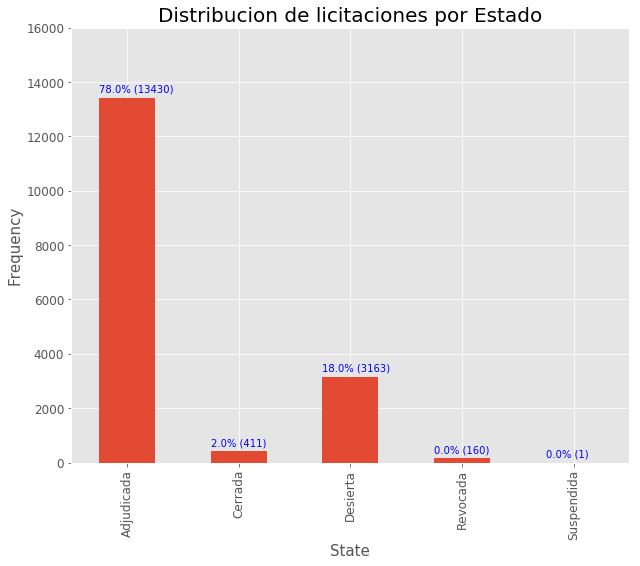

In [9]:
# rename deserted to shorter names
rename_func = lambda x: x if 'Desierta' not in x else 'Desierta'
renamed_tender_df = tender_df.copy()
renamed_tender_df['Estado'] = renamed_tender_df['Estado'].apply(rename_func)

tender_state_df = renamed_tender_df.groupby('Estado')['CodigoExterno'].count()
ax = tender_state_df.plot.bar(figsize=(10, 8));
_ = ax.set_ylabel('Frequency', fontsize=15);
_ = ax.set_xlabel('State', fontsize=15);
_ = ax.set_ylim([0, 16000]);
_ = ax.set_title('Distribucion de licitaciones por Estado', fontsize=20);
_ = ax.tick_params(labelsize=12);

# add value label
total_count = tender_state_df.sum()
computer_perc = lambda x, total, dp: int(x / total * (10 ** dp)) / (10 ** dp) * 100
for i, v in enumerate(tender_state_df.tolist()):
    _ = ax.text(i - 0.25, v + 200, '{}% ({})'.format(computer_perc(v, total_count, 2), v), color='blue', fontsize=10);

plt.show()

Tenemos una cantidad significativa de licitaciones desiertas (cercanas al 20%)

### Qué significa que la licitación se encuentre Desierta? -> [o art. 3 ó 9 Ley 19.886](https://www.leychile.cl/Navegar?idNorma=213004&r=1)
#### Art 3 Ley 19.886
Artículo 3º.- Quedan excluidos de la aplicación de la presente ley:
1. Las contrataciones de personal de la Administración del Estado reguladas por estatutos especiales y los contratos a honorarios que se celebren con personas naturales para que presten servicios a los organismos públicos, cualquiera que sea la fuente legal en que se sustenten;
2. Los convenios que celebren entre sí los organismos públicos enumerados en el artículo 2º, inciso primero, del decreto ley Nº 1.263, de 1975, Ley Orgánica de Administración Financiera del Estado, y sus modificaciones;
3. Los contratos efectuados de acuerdo con el procedimiento específico de un organismo internacional, asociados a créditos o aportes que éste otorgue;
...

#### Art 9 Ley 19.886
Artículo 9º.- El órgano contratante declarará inadmisibles las ofertas cuando éstas no cumplieren los requisitos establecidos en las bases. Declarará desierta una licitación cuando no se presenten ofertas, o bien, cuando éstas no resulten convenientes a sus intereses.
En ambos casos la declaración deberá ser por resolución fundada.

## Distribución de licitaciones por Región  

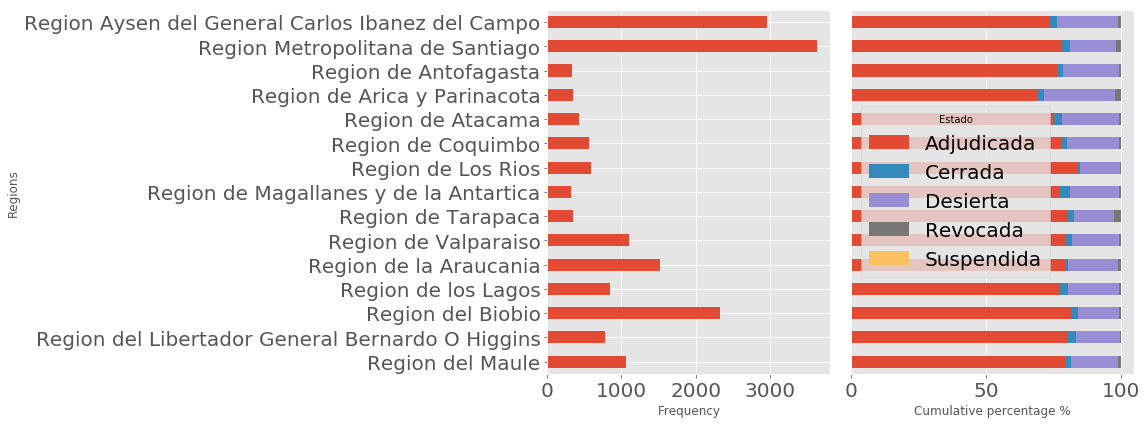

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)

# group by region
grouped_region = tender_df.groupby('CompradorRegionUnidad').size()
grouped_region.sort_index(inplace=True, ascending=False)
_ = grouped_region.plot(kind='barh', figsize=(16, 6), ax=axes[0])
_ = axes[0].set_xlabel('Frequency')
_ = axes[0].set_ylabel('Regions')

# distribution of tender states within regions
grouped_region_state = tender_df.groupby(['CompradorRegionUnidad', 'Estado']).size()
grouped_region_state = grouped_region_state.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()
grouped_region_state.sort_index(inplace=True, ascending=False)
_ = grouped_region_state.plot(kind='barh', stacked=True, figsize=(16, 6), ax=axes[1])
_ = axes[1].set_yticks(ticks=[])
_ = axes[1].set_ylabel('')
_ = axes[1].set_xlabel('Cumulative percentage %')
plt.tight_layout()

Llama la atención que la Region de Aysén tiene más organizaciones que solicitan licitaciones en comparación a la Region Metropolitana durante el mes de Noviembre 2016. Será interesante investigar si el tipo de productos de estas licitaciones nos puede ayudar a dilucidar este comportamiento. 

## Distribución de licitaciones por tiempo de demora

In [11]:
cols = ['CodigoExterno'] + list(filter(lambda colname: 'Fecha' in colname, tender_df.columns))
# only analyze sold tenders
ttime_df = tender_df.loc[(tender_df['Estado'] == 'Adjudicada'), cols]

ttime_df['time_duration_days'] = (ttime_df['FechasFechaCierre'] - ttime_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_df['time_sale_days'] = (ttime_df['FechasFechaAdjudicacion'] - ttime_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_df['time_decision_days'] = (ttime_df['FechasFechaEstimadaAdjudicacion'] - ttime_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_df['time_estimation_error_days'] = (ttime_df['FechasFechaEstimadaAdjudicacion'] - ttime_df['FechasFechaAdjudicacion']) / np.timedelta64(1, 'D')

### Make continuous categorical

In [12]:
min_time_duration = ttime_df['time_duration_days'].min()
max_time_duration = ttime_df['time_duration_days'].max()

min_time_sale = ttime_df['time_sale_days'].min()
max_time_sale = ttime_df['time_sale_days'].max()

min_time_decision = ttime_df['time_decision_days'].min()
max_time_decision = ttime_df['time_decision_days'].max()

min_time_estimation_error = ttime_df['time_estimation_error_days'].min()
max_time_estimation_error = ttime_df['time_estimation_error_days'].max()

print('Min time duration: {}\nMax time duration: {}'.format(min_time_duration, max_time_duration))
print('Min sale time: {}\nMax sale time: {}'.format(min_time_sale, max_time_sale))
print('Min decision time: {}\nMax decision time: {}'.format(min_time_decision, max_time_decision))
print('Min estimation error time: {}\nMax estimation error time: {}'.format(min_time_estimation_error, 
                                                                           max_time_estimation_error))
bin_sz = 10
bins_time_duration = [ind * bin_sz for ind in range(0, int(max_time_duration) // bin_sz + 1)]
bins_time_sale = [ind * bin_sz for ind in range(0, int(max_time_sale) // bin_sz + 1)]
bins_time_decision = [ind * bin_sz for ind in range(0, int(max_time_decision) // bin_sz + 1)]
bins_time_estimation = [ind * bin_sz for ind in range(0, int(max_time_estimation_error) // bin_sz + 1)]

ttime_df['time_duration_days_cat'] = pd.cut(ttime_df['time_duration_days'], bins=bins_time_duration)
ttime_df['time_sale_days_cat'] = pd.cut(ttime_df['time_sale_days'], bins=bins_time_sale)
ttime_df['time_decision_days_cat'] = pd.cut(ttime_df['time_decision_days'], bins=bins_time_decision)
ttime_df['time_estimation_error_days_cat'] = pd.cut(ttime_df['time_estimation_error_days'], bins=bins_time_estimation)

Min time duration: 0.0012789699074074075
Max time duration: 176.14305555555555
Min sale time: 0.004895520833333333
Max sale time: 285.2177521990741
Min decision time: 5.158496099537037
Max decision time: 752.2580340277777
Min estimation error time: -240.71942974537038
Max estimation error time: 682.053589201389


Creamos columnas con tiempos que de demora en comenzar ventas, en cerrar la licitacion y el error entre tiempo estimado en que comienzan las ventas y el tiempo en que realmente comenzo a venderse. 

Para ello hacemos los siguientes procedimientos: 
- limpiamos las fechas (date_sale, date_publication, date_close, date_sale_estimated)
- las convertimos a fecha para poder restas y obtener un valor en dias de diferencia

Los tiempos obtenidos son los siguientes: 
- **tiempo que demora entre que se publica la licitacion y se cierra** --> tender_duration = date_close - date_publication
- **time taken: (tiempo total de la licitacion)** time_sale = date_sale - date_publication

### Distribution of tender duration (date_close - date_publication)

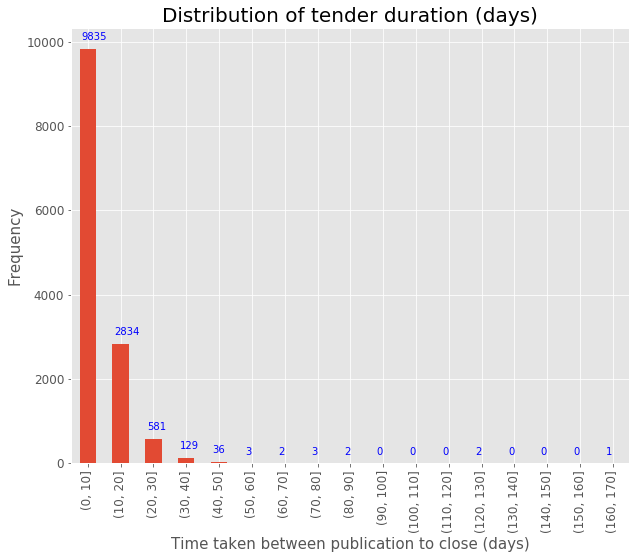

In [13]:
ttime_duration_df = ttime_df.groupby('time_duration_days_cat')['CodigoExterno'].count()
ax = ttime_duration_df.plot.bar(figsize=(10, 8));
_ = ax.set_xlabel('Time taken between publication to close (days)', fontsize=15);
_ = ax.set_ylabel('Frequency', fontsize=15);
_ = ax.set_title('Distribution of tender duration (days)', fontsize=20);
_ = ax.tick_params(labelsize=12)

for i, v in enumerate(ttime_duration_df.tolist()):
    _ = ax.text(i - 0.2, v + 200, str(v), color='blue', fontsize=10);

plt.show()

En este caso es dificil hacer un análisis más detallado. Ahora nos focalizaremos las licitaciones de menor duración.

Number of tenders with duration < 50 days: 13415/13430 (0.99%)
Min duration time: 0.0012789699074074075
Max duration time: 48.95692461805555


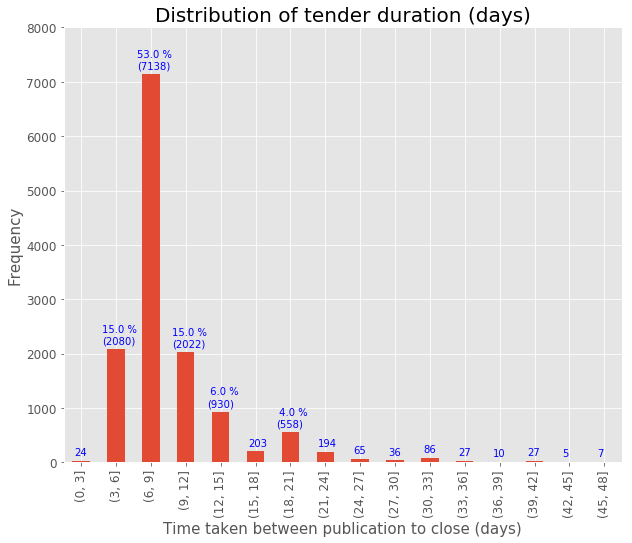

In [14]:
day_threshold = 50
ttime_df1 = ttime_df.loc[(ttime_df['time_duration_days'] < day_threshold),:]
nrow = ttime_df1.shape[0]
total = ttime_df.shape[0]
perc = int(nrow / total * 100) / 100
print('Number of tenders with duration < {} days: {}/{} ({}%)'.format(day_threshold,
                                                                     nrow, total, perc))
min_time_duration = ttime_df1['time_duration_days'].min()
max_time_duration = ttime_df1['time_duration_days'].max()
print('Min duration time: {}\nMax duration time: {}'.format(min_time_duration, max_time_duration))

bin_sz = 3
bins = [ind * bin_sz for ind in range(0, int(max_time_duration) // bin_sz + 1)]

ttime_df1['time_duration_days_cat'] = pd.cut(ttime_df1.loc[:,'time_duration_days'], bins=bins)

ttime_duration_df1 = ttime_df1.groupby('time_duration_days_cat')['CodigoExterno'].count()
ax = ttime_duration_df1.plot.bar(figsize=(10, 8))
_ = ax.set_ylim([0, 8000])
_ = ax.set_xlabel('Time taken between publication to close (days)', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of tender duration (days)', fontsize=20)
_ = ax.tick_params(labelsize=12)

computer_perc = lambda x, total, dp: int(x / total * (10 ** dp)) / int(10 ** dp) * 100
for i, v in enumerate(ttime_duration_df1.tolist()):
    if v > 500:
        _ = ax.text(i - 0.4, v + 100, '{:^5}%\n({})'.format(computer_perc(v, nrow, 2), v), color='blue', fontsize=10)
    else:
        _ = ax.text(i - 0.2, v + 100, str(v), color='blue', fontsize=10)
plt.show()

Si vemos las licitaciones con una duracion menor a 50 días podremos analizar el 99% de las licitaciones que ya estan en el mercado (sales), lo que es suficiente en terminos de tamaño. 
Podemos identificar que la mayoría de las licitaciones tienen una duración entre 7 y 9 días y hay muy pocas que tienen una duracion de más de 24 días. De esto se puede inferir que la mayorías de las organizaciones quieren tener su producto lo más rapido posible (alrededor de una semana) y esto lo hacen reduciendo los plazos que tienen los oferentes para participar de la licitación. 

Tambien será interesante analizar la caída del plazo entre 15 y 18 días.

### Distribución del tiempo de venta (date_sale - date_publication)

Number of tenders with sale duration < 200 days: 13386/13430 (0.99%)
Min sale days: 0.004895520833333333
Max sale days: 199.70378224537038


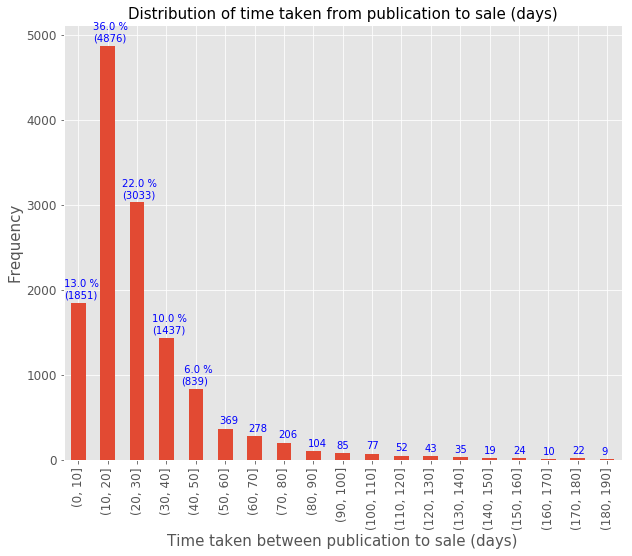

In [15]:
day_threshold = 200
ttime_sale_df1 = ttime_df.loc[(ttime_df['time_sale_days'] < day_threshold),:]
nrow = ttime_sale_df1.shape[0]
total = ttime_df.shape[0]
perc = int(nrow / total * 100) / 100
print('Number of tenders with sale duration < {} days: {}/{} ({}%)'.format(day_threshold, 
                                                                     nrow, total, perc))
min_sale_days = ttime_sale_df1['time_sale_days'].min()
max_sale_days = ttime_sale_df1['time_sale_days'].max()
print('Min sale days: {}\nMax sale days: {}'.format(min_sale_days, max_sale_days))

bin_sz = 10
bins = [ind * bin_sz for ind in range(0, int(max_sale_days) // bin_sz + 1)]
ttime_sale_df1['time_sale_days_cat'] = pd.cut(ttime_sale_df1.loc[:,'time_sale_days'], bins=bins)

ttime_sale_df1 = ttime_sale_df1.groupby('time_sale_days_cat')['CodigoExterno'].count()
ax = ttime_sale_df1.plot.bar(figsize=(10, 8))
_ = ax.set_xlabel('Time taken between publication to sale (days)', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of time taken from publication to sale (days)', fontsize=15)
_ = ax.tick_params(labelsize=12)

computer_perc = lambda x, total, dp: int(x / total * (10 ** dp)) / int(10 ** dp) * int(100)
for i, v in enumerate(ttime_sale_df1.tolist()):
    perc = computer_perc(v, nrow, 2)
    if perc > 5:
        _ = ax.text(i - 0.5, v + 50, '{:^5}%\n({})'.format(perc, v), color='blue', fontsize=10)
    else:
        _ = ax.text(i - 0.2, v + 50, str(v), color='blue', fontsize=10)
plt.show()

Si vemos las licitaciones que fueron vendidas en 200 días se ve un longtail donde la mayoría de las licitaciones fueron vendidas en 30 días (1 mes aprox) y las licitaciones que le siguen disminuyen considerablemente. Sin embargo, esto también puede ocurrir porque las licitaciones no son vendidas (por cualquier motivo) y en ese mismo momento son declaradas como desiertas. Recordar del grafico anterior que aproximadamente el 20% de las licitaciones son declaradas desiertas. Esto tiene sentido con el comportamiento que se observa en este caso donde la mayoría de las licitaciones tienen una duración de una semana.

## Análisis de licitacones desiertas

### Tipo de licitaciones desiertas

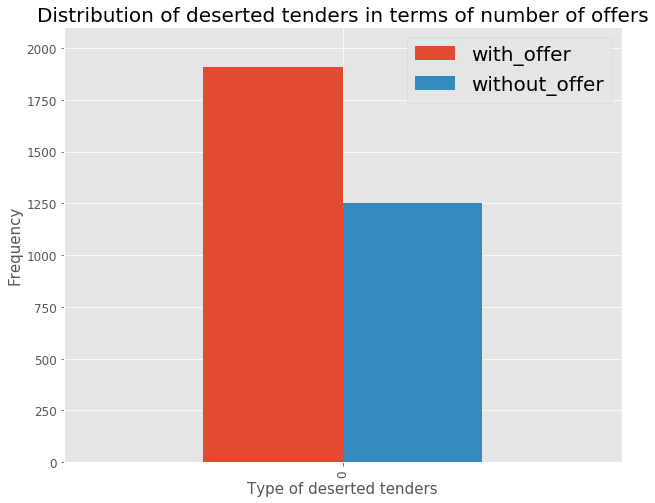

In [16]:
deserted_tenders = tender_df[(tender_df['Estado'].str.contains('Desierta'))]
# categorized by number of offers
deserted_tenders = deserted_tenders.groupby('AdjudicacionNumeroOferentes')['CodigoExterno'].count()
# separated into two bins, those with offer and those without
deserted_tenders_separated = pd.DataFrame({'without_offer': np.sum(deserted_tenders[(deserted_tenders.index == 0)]),
                                          'with_offer': np.sum(deserted_tenders[(deserted_tenders.index > 0)])},
                                         index=[0])
ax = deserted_tenders_separated.plot.bar(figsize=(10, 8))
_ = ax.set_ylim([0, 2100])
_ = ax.set_xlabel('Type of deserted tenders', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of deserted tenders in terms of number of offers', fontsize=20)
_ = ax.tick_params(labelsize=12)

plt.show()

In [17]:
without_offer_perc = deserted_tenders_separated['without_offer'] / deserted_tenders_separated.iloc[0, :].sum() * 100
with_offer_perc = deserted_tenders_separated['with_offer'] / deserted_tenders_separated.iloc[0, :].sum() * 100
print('{:.2f}% without offer\n{:.2f}% with offer'.format(without_offer_perc[0], with_offer_perc[0]))

39.61% without offer
60.39% with offer


Encontramos que 1250 de las ofertas desiertas se deben a la falta de ofertas, por lo que sería adecuado investigar sobre la causa de esto en terminos de tipo, region u organización.

### Distribución del tiempo de venta de ofertas desiertas 

In [18]:
deserted_tenders = tender_df[(tender_df['Estado'].str.contains('Desierta'))&
                            (tender_df['AdjudicacionNumeroOferentes'] > 0)]
# compute different datetimes
cols = ['CodigoExterno'] + list(filter(lambda colname: 'Fecha' in colname, tender_df.columns))
# only analyze sold tenders
ttime_deserted_df = deserted_tenders.loc[:,cols]

cmp_diff_days = lambda row, col0, col1: (row[col0] - row[col1]) / np.timedelta64(1, 'D')

ttime_deserted_df['time_duration_days'] = (ttime_deserted_df['FechasFechaCierre'] - ttime_deserted_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_deserted_df['time_sale_days'] = (ttime_deserted_df['FechasFechaAdjudicacion'] - ttime_deserted_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_deserted_df['time_decision_days'] = (ttime_deserted_df['FechasFechaEstimadaAdjudicacion'] - ttime_deserted_df['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
ttime_deserted_df['time_estimation_error_days'] = (ttime_deserted_df['FechasFechaEstimadaAdjudicacion'] - ttime_deserted_df['FechasFechaAdjudicacion']) / np.timedelta64(1, 'D')

In [19]:
ttime_deserted_df['time_duration_days_cat'] = pd.cut(ttime_deserted_df['time_duration_days'], bins=10)
ttime_deserted_df['time_sale_days_cat'] = pd.cut(ttime_deserted_df['time_sale_days'], bins=10)
ttime_deserted_df['time_decision_days_cat'] = pd.cut(ttime_deserted_df['time_decision_days'], bins=10)
ttime_deserted_df['time_estimation_error_days_cat'] = pd.cut(ttime_deserted_df['time_estimation_error_days'], bins=10)

Number of deserted tenders with sale duration < 100 days: 1819/1910 (0.95%)
Min sale days: 6.0001062152777775
Max sale days: 99.92152164351852


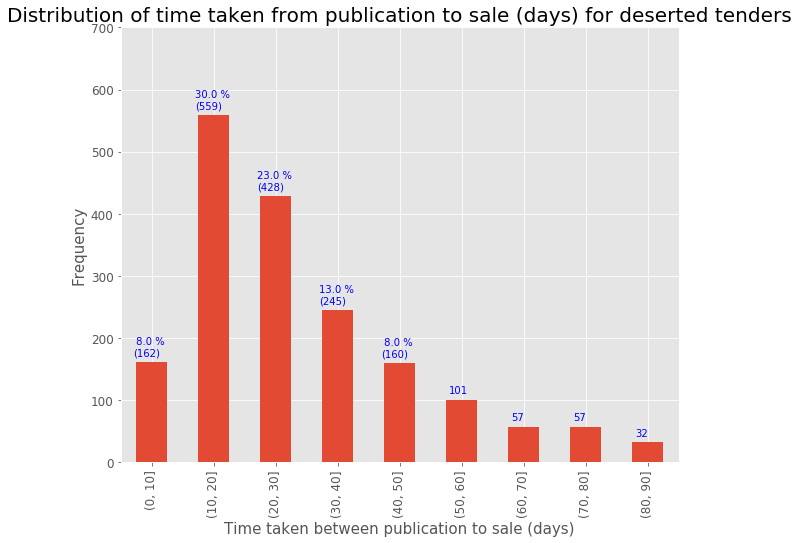

In [20]:
day_threshold = 100
ttime_deserted_sale_df1 = ttime_deserted_df.loc[(ttime_deserted_df['time_sale_days'] < day_threshold),:]
nrow = ttime_deserted_sale_df1.shape[0]
total = ttime_deserted_df.shape[0]
perc = int(nrow / total * 100) / 100
print('Number of deserted tenders with sale duration < {} days: {}/{} ({}%)'.format(day_threshold, 
                                                                     nrow, total, perc))

min_sale_days = ttime_deserted_sale_df1['time_sale_days'].min()
max_sale_days = ttime_deserted_sale_df1['time_sale_days'].max()
print('Min sale days: {}\nMax sale days: {}'.format(min_sale_days, max_sale_days))

bin_sz = 10
bins = [ind * bin_sz for ind in range(0, int(max_sale_days) // bin_sz + 1)]
ttime_deserted_sale_df1['time_sale_days_cat'] = pd.cut(ttime_deserted_sale_df1['time_sale_days'], bins=bins)

ttime_deserted_sale_df1 = ttime_deserted_sale_df1.groupby('time_sale_days_cat')['CodigoExterno'].count()
ax = ttime_deserted_sale_df1.plot.bar(figsize=(10, 8))
_ = ax.set_ylim([0, 700])
_ = ax.set_xlabel('Time taken between publication to sale (days)', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of time taken from publication to sale (days) for deserted tenders', fontsize=20)
_ = ax.tick_params(labelsize=12)

computer_perc = lambda x, total, dp: int(x / total * (10 ** dp)) / int(10 ** dp) * int(100)
for i, v in enumerate(ttime_deserted_sale_df1.tolist()):
    perc = computer_perc(v, nrow, 2)
    if perc > 5:
        _ = ax.text(i - 0.3, v + 10, '{:^5.1f}%\n({})'.format(perc, v), color='blue', fontsize=10)
    else:
        _ = ax.text(i - 0.2, v + 10, str(v), color='blue', fontsize=10)
plt.show()

Podemos ver que el tiempo no es un factor relevante en que se abandone una licitación. Por ejemplo, el 13% de las licitaciones desiertas tienen un tiempo de venta entre 31 y 40 días; 10% de las licitaciones son vendidas entre 31 y 40 días. 
Pareciera que la distribucion de licitaciones desiertas es similar It seems that the distribution for deserted tenders is similar to the distribution of sold tenders. 
Llama la atencion que no existe diferencia entre estas dos. 
Esto sugiere que tal vez el tiempo no juega un rol importante en determinar la cantidad de licitaciones. 

## Ofertas

### Distribucion de licitaciones por numero de oferentes

Min num of offer: 0.0
Max num of offer: 69.0


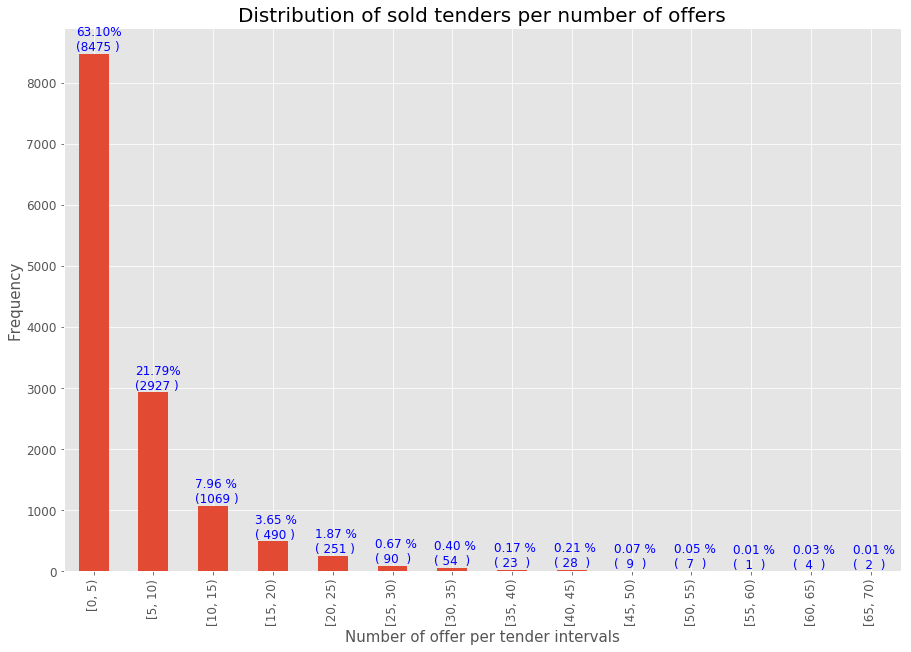

In [21]:
tender_df_modified = tender_df.loc[(tender_df['Estado'].str.contains('Adjudicada')), :]
offer_count_df = tender_df_modified.groupby('AdjudicacionNumeroOferentes')['CodigoExterno'].count().to_frame()

min_offer = offer_count_df.index.min()
max_offer = offer_count_df.index.max()
print('Min num of offer: {}\nMax num of offer: {}'.format(min_offer, max_offer))

interval_sz = 5
bins = [ind * interval_sz for ind in range(0, int(max_offer) // interval_sz + 2)]
offer_count_df['count_cat'] = pd.cut(offer_count_df.index.tolist(), bins=bins, include_lowest=True, right=False)

offer_count_cat = offer_count_df.groupby('count_cat')['CodigoExterno'].sum()

ax = offer_count_cat.plot.bar(figsize=(15, 10))
_ = ax.set_xlabel('Number of offer per tender intervals', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of sold tenders per number of offers', fontsize=20)
_ = ax.tick_params(labelsize=12)

total = offer_count_cat.sum()
cmp_perc = lambda x, total: x / total * 100
for i, v in enumerate(offer_count_cat.tolist()):
    if np.isnan(v):
        _ = ax.text(i - 0.3, 50, '{:^5.2f}%\n({:^5})'.format(cmp_perc(v, total), v), fontsize=12, color='blue')
    else:
        _ = ax.text(i - 0.3, v + 50, '{:^5.2f}%\n({:^5.0f})'.format(cmp_perc(v, total), v), fontsize=12, color='blue')

plt.show()


La mayoría (61%) tiene entre 1 y 5 ofertas, observamos nuevamente un longtail para el numero de ofertas por licitación. 
Una posible idea de investigación será ver las características de estas licitaciones que tienen a muchos oferentes. 
Uno tendería a pensar que a las organizaciones les conviene tener muchos oferentes para tener más alternativas de elección y también se reduce el precio porque hay más competencia.

### Distribución de licitaciones desiertas por número de ofertas 

Min num of offer: 0.0
Max num of offer: 42.0


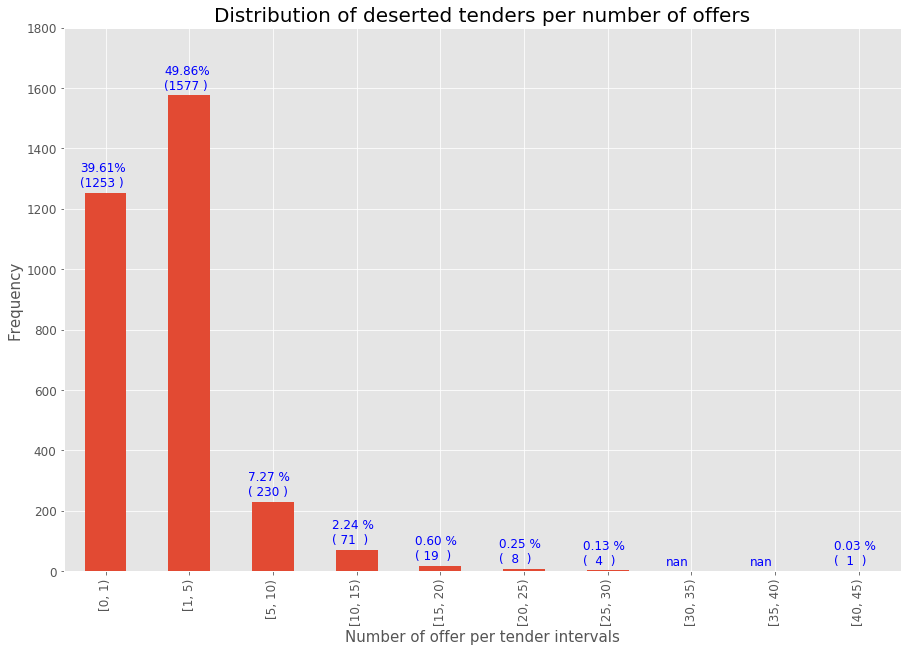

In [22]:
tender_df_modified = tender_df.loc[(tender_df['Estado'].str.contains('Desierta')), :]
offer_count_df = tender_df_modified.groupby('AdjudicacionNumeroOferentes')['CodigoExterno'].count().to_frame()

min_offer = offer_count_df.index.min()
max_offer = offer_count_df.index.max()
print('Min num of offer: {}\nMax num of offer: {}'.format(min_offer, max_offer))

interval_sz = 5
bins = [0, 1] + [ind * interval_sz for ind in range(1, int(max_offer) // interval_sz + 2)]
offer_count_df['count_cat'] = pd.cut(offer_count_df.index.tolist(), bins=bins, include_lowest=True, right=False)

offer_count_cat = offer_count_df.groupby('count_cat')['CodigoExterno'].sum()

ax = offer_count_cat.plot.bar(figsize=(15, 10))
_ = ax.set_ylim([0, 1800])
_ = ax.set_xlabel('Number of offer per tender intervals', fontsize=15)
_ = ax.set_ylabel('Frequency', fontsize=15)
_ = ax.set_title('Distribution of deserted tenders per number of offers', fontsize=20)
_ = ax.tick_params(labelsize=12)

total = offer_count_cat.sum()
cmp_perc = lambda x, total: x / total * 100
for i, v in enumerate(offer_count_cat.tolist()):
    if np.isnan(v):
        _ = ax.text(i - 0.3, 20, str(v), fontsize=12, color='blue')
    else:
        _ = ax.text(i - 0.3, v + 20, '{:^5.2f}%\n({:^5.0f})'.format(cmp_perc(v, total), v), fontsize=12, color='blue')

plt.show()


Obtenemos que la mayoría tiene entre 1 y 4 oferentes. En comparación con las licitaciones vendidas, hay muchas menos ofertas desiertas que tienen más de 5 oferentes. Tan solo el 7% tiene entre 5 y 9 ofertas, mientras que tan solo el 22% de las ofertas vendidas tienen entre 5 y 9 oferentes. Esto nos lleva a pensar que la falta de ofertas es uno de los principales motivos por los que las organizaciones declaran como desiertas las licitaciones de acuerdo al articulo 9 de la ley de licitaciones desiertas.

### Distribucion de licitaciones por monto

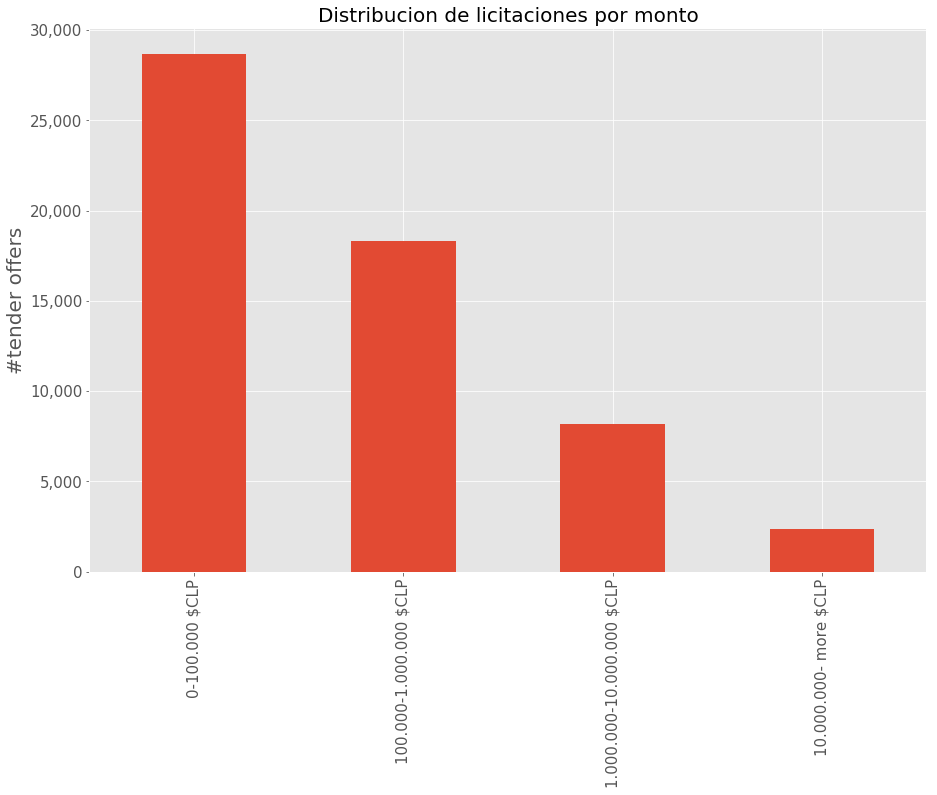

In [23]:
_ = %matplotlib inline 

tprod_df0 = tprod_df.copy(deep=True)

tprod_df0['tender_price'] = tprod_df0['AdjudicacionCantidad'] * tprod_df0['AdjudicacionMontoUnitario']

montos = tprod_df0['tender_price']

tramos_monto = pd.cut(montos, bins=[ 0, 100000, 1000000,10000000, 20000000000], include_lowest=False)

tramos_norm = tramos_monto.value_counts(sort=False)
graph_amounts = tramos_norm.plot.bar(figsize=(15,10))

_ = graph_amounts.set_ylabel('#tender offers', fontsize=20)

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
_ = graph_amounts.yaxis.set_major_formatter(tick)
_ = graph_amounts.tick_params(labelsize=15)

_ = graph_amounts.set_xticklabels(['0-100.000 $CLP', '100.000-1.000.000 $CLP',
                                  '1.000.000-10.000.000 $CLP','10.000.000- more $CLP'], fontsize=15)

_ = graph_amounts.set_title('Distribucion de licitaciones por monto', fontsize=20)



Podemos observar otra distribución donde la mayoría de las licitaciones se distribuye entre 0 y 100.000 pesos chilenos, seguido de un menor numero de licitaciones entre 100.000 y 1 millón de pesos chilenos. Será relevante saber las características estos productos que tienen más frecuencia y son de más bajo monto. <br> <br>
Algunos atributos relevantes pueden ser:
- tasa de adjudicación.
- tipo de productos. 
- organizaciones que requieren productos de este monto.
- rubro al que pertenecen.

# 3. Tematica o problematica central y describir como se abordara inicialmente

La problemática central es que tenemos una fuente de datos sobre las licitaciones de esta plataforma pero hasta ahora no existen estudios hecho para entenderlo. Hasta este momento aplicaciones que tratan de entender los datos están limitadas a análisis sencillos por ejemplo, la participación en montos por sectores [10]. 
Esta claro que desde el analisis breve desde la seccion anterior no es suficiente para identificar todos los problemas potenciales. Por lo tanto, 
1. el enfoque principal es tratar de entender el dataset y especificamente cuantificar que significa una buena licitacion desde las perspectivas de los distintos "stakeholders", i.e., organizaciones publicas, proveedores, y sectores. Se puede lograr este objetivo a través de la tarea clasificación y clustering usando algoritmos como decision tree, k-means clustering y etc.
2. Hemos identificado que hay ~20% licitaciones desiertas. Ademas, hay ~40% sin oferentes. Podemos tratar de entender las caracteristicas de este tipo de licitaciones a traves de tecnicas de clustering y clasificacion. Luego, ver si es posible predicir si una licitacion va a ser desierta usando los atributos identificados. Tambien, podemos hacer recomendaciones a organizacion publicas sobre como se puede evitar la desierta de sus licitaciones.
3. Identificamos que la mayoria de las licitaciones solamente tiene [0 - 5] oferentes. De nuevo, a traves de tecnicas de clasificacion y clustering podemos aprender las caracteristicas que describen licitaciones con mas oferentes y luego hacer tareas de predicciones o recomendaciones para mejorar el numero de oferentes por licitaciones. Pero una limitacion es que la falta de oferentes puede ser porque el mercado que realmente no existe muchos proveedores para algunos productos. Podemos investigar sobre este aspecto mirando la distribucion de los proveedores.

Algunos problemas generales:
- Cuales son los rubros donde la tasa de aprobación es mayor
- Qué tipos de productos y servicios es conveniente ofrecer a empresas públicas que los necesitan en los concursos por licitaciones. 
- Tareas de predicciones: una intuición es que si la organización pública extender el tiempo de licitación, esta licitación va a tener más oferentes y por lo tanto mejor precio. Entonces puede hacer una tarea de predicción del precio adjudicado de las licitaciones según los distintos factores, e.g., tiempo de licitacion, sector, y región de la organización pública.

# 4. Trabajo relacionado

Muchos estudios se han hecho para determinar si un producto va a tener una buena llegada para el segmento objetivo al que está dirigido. Un estudio que está relacionado es J Ben Schafer et.al [6], donde se obtienen algoritmos de recomendación de productos comprados en una plataforma online a usuarios dependiendo de compras hechas anteriormente por el mismo usuario u otros usuarios dentro de la comunidad en línea. Otro estudio relevante es de Patrick McCole et.al [7] que obtiene las características que más influyen en que un usuario compre productos de e-commerce relacionados a servicios. 
Si bien estos estudios tienen relación con los procesos de compra y venta de bienes y servicios nos puede servir en este caso porque nuestro objetivo es determinar qué características de los productos o servicios que se ponen a disposición en un concurso de licitación pública tiene más chances de adjudicarse, pero en nuestro caso no nos enfocamos en características de los usuarios sino que de los productos a ofrecer. 

Respecto a estudios sobre licitaciones públicas la mayoría se ha hecho para estudiar fenómenos económicos y sociológicos, como el estudio de Francisca Silva y Nicolás Majluf que estudiaron cómo las licitaciones en Chile son influenciadas por lazos familiares y relaciones sociales entre directores de empresas oferentes y las que contratan los bienes y servicios. Otro estudio es el estudio de Claudio Weber et.al, que investiga sobre el funcionamiento de las licitaciones en Brasil y sus normas de regulación que al dar  demasiada participación a los agentes públicos se ejercen arbitrariedades, dirigiendo las licitaciones a ciertas compañías favorecidas.  Nosotros con este estudio pretendemos darle un enfoque distinto a este tema y analizar los datos para darle una perspectiva del mercado a los participantes del concurso de licitación. 


# Hito 2

# Resumen de feedback

### 1. Motivacion
- Porque es de interés? De nuevo, puede ser clavo o ustedes pueden saberlo, pero deben hacerlo más explícito
- Puede ser mas punctual, hay mucho detalles donde se pierde la idea general

En la presentacion, no tuvimos la primera parte del informe de Hito 1. Con la introduccion creamos que ya tiene suficiente detalle para motivar la investigacion de este dataset. En este Hito 2, enfocamos con tareas de DM para dar ideas mas punctuales.

#### (de profesora)
- Motivar el estudio (Ha mencionado arriba)
- Motivar una investigacion de desafio tecnico (No aplica)
- Explica teminos tecnicos (No tenemos este problema dado la unica palabra tecnica es "licitacion")

### 2. Hipotesis
- Creo que el hipotesis esta, pero no esta explicitamente dicho en la presentacion.
- Demasiado general, consiste en analisis de datos, pero no queda muy claro el objetivo del proyecto
- No fue mucho un hipotesis, fue mas que nada una descripcion de lo que se iba a hacer, no lo que se espera encontrar
- Falto presentar al inicio ideas mas precisas de las problematicas a abordar

Como ha mencionado antes, en este Hito 2 las ideas son muchas mas precisas dado que aplicamos tecnicas de DM con cual requiere input feature y target output.

#### (de profesora)
- Explicita el problema central
- Considera los problemas centrales y no es solamente aplicar tecnicas

Presentamos los problemas centrales en la siguiente seccion.

### 3. Descripcion
- No me convencio el argumento del mes para decir que Aysen es la region con mas licitaciones
- Define bien la hipotesis
- Graficos muy pequenos y algunos no poseen labels

Encontramos que Aysen no es la region con mas licitaciones (fue error de antes). Hay hipotesis claros y los graficos son de suficiente tamano y tienen labels. Algunos de los graficos son muy pequenos en el informe, pero dado el usuario puede hacer zoom, creamos que esta bien. Los tamanos de estos graficos fueron necesarios.

#### (de profesora)
- Explica sobre el fuente de dato (esta bien explicado)
- Deja los detalles en el informe y solamente muestra las ideas centrales en la presentacion

Intentamos dejar todas las detalles en este informe y solamente explica las ideas centrales en la presentacion.

### 4. Calidad general de la presentacion
- Plantea preguntas


# Hipotesis central

### 1. Queremos entender que es una buena licitacion?
Uno puede directamente pensar que una buena licitacion es una licitacion adjudicada pero se puede definir una buena licitacion por distintas caracteristicas y desde distintas perspectivas. 

Por ejemplo, desde la vista de las organizaciones publicas (i.e., compradores), lo mas importante quizas es el precio de oferentes. Por lo tanto, a traves tecnicas de DM queremos entender y quizas clasificar estas distintas interpretaciones de una "buena" licitacion.

### 2. Licitaciones de distintas regiones y productos tienen distintas comportamiento?
En pesar de tener la misma plataforma, es razonable pensar que licitaciones relacionada a distintas regiones y productos se comportan en distinta manera. Uno se puede tomar en cuenta de esto con el uso de feature cuando aplica tecnicas de DM. Pero de hecho en esta manera no esta contestando la pregunta SI licitaciones de distintas regiones / productos tienen distintas comportamiento! Ademas una parte de DM es la reduccion de dimensionalidad. 

## Problemas identificados

### 1) No todos los items de una licitacion adjudicada son adjudicadas

In [24]:
def has_nan(df):
    return df['AdjudicacionMontoUnitario'].isnull().any() and \
            df['AdjudicacionMontoUnitario'].unique().shape[0] > 1
    
to_choose = tprod_df.groupby('CodigoExterno', as_index=False).apply(has_nan)
mixed_tid_list = tender_df.loc[to_choose, 'CodigoExterno']
tid0 = mixed_tid_list.values[0]
tprod0 = tprod_df[(tprod_df['CodigoExterno']==tid0)]
tprod0_sold = tprod0.shape[0] - tprod0['AdjudicacionMontoUnitario'].isnull().sum()
print('{} (Adjudicada) tiene {} productos pero solamente {} son adjudicadas.'.format(tid0, tprod0.shape[0], tprod0_sold))

1020-45-LE16 (Adjudicada) tiene 6 productos pero solamente 3 son adjudicadas.


### 2) Hay productos adjudicados duplicados
La informacion de cada licitacion esta en el formato del JSON y la informacion sobre los productos de la licitacion estan en una lista y tiene un key "Listado". Ademas, hay un key "Cantidad" que indica cuantos elementos (productos) hay en la lista. La informacion acerca cada uno de los productos esta en un diccionario.

Cuando convertimos los productos de la licitacion al formato dataframe, encontramos que existen filas duplicadas. Esto significa que hay productos de licitaciones duplicados. 

Para esto, creamos un nuevo feature "tender_product_duplicated" pero dejamos los duplicados en tprod_df. Esto es porque luego encontramos que existe una limitacion de la calidad del dato. Las filas duplicadas pueden ser de distinto productos pero por la informacion parecen que son iguales. Por ejemplo, Producto 1 tiene f1 = 1, f2 = 2, f3 = 3 y Producto 2 tiene f1 = 1, f2 = 2, f3 = 4. Pero en el sistema, los stakeholders solamente pusieron f1 y f2 y no guardaron f3. Entonces, para los usuarios del dato, Producto 1 == Producto 2.

In [25]:
tprod_df[(tprod_df['CodigoExterno']=='2963-65-LR16')&(tprod_df['AdjudicacionNombreProveedor']=='NOVOFARMA SERVICE S A')]

,AdjudicacionCantidad,AdjudicacionMontoUnitario,AdjudicacionNombreProveedor,AdjudicacionRutProveedor,Cantidad,Categoria,CodigoCategoria,CodigoExterno,CodigoProducto,Correlativo,Descripcion,NombreProducto,UnidadMedida
38682,1.0,1.0,NOVOFARMA SERVICE S A,96.945.670-2,1.0,Equipamiento y suministros medicos / Articulos medicos para urgencias y atencion en terreno / Contenedores de almacenaje para servicios medicos de urgencia,42171900,2963-65-LR16,42171903,1,ADQUISICION DE MEDICAMENTOS INSUMOS MEDICOS Y DENTALES E INSTRUMENTAL,Cajas de medicamentos de servicios medicos de urgencia,Unidad
38702,1.0,1.0,NOVOFARMA SERVICE S A,96.945.670-2,1.0,Equipamiento y suministros medicos / Articulos medicos para urgencias y atencion en terreno / Contenedores de almacenaje para servicios medicos de urgencia,42171900,2963-65-LR16,42171903,1,ADQUISICION DE MEDICAMENTOS INSUMOS MEDICOS Y DENTALES E INSTRUMENTAL,Cajas de medicamentos de servicios medicos de urgencia,Unidad


Por ejemplo, para la licitacion "2963-65-LR16", hay dos productos entry que tienen la misma informacion. Los dos fueron adjudicados al proveedor "NOVOFARMA SERVICE S A". Pero si uno va al contracto en http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=OHT40CuRXq0wrx7/seAF/MzMeN6355siaFM+bE9oIZc=, uno va a ver que de hecho "Novofarma" tiene dos departamentos: "NOVOFARMA SERVICE S.A" y "NOVOFARMA PHARMAVIDA" y cada uno esta proveyendo distintos productos en esta licitacion.

## Experimentos y resultados preliminares

### Classificacion con los target es_adjudicadas
Hicimos experimentos preliminares para clasificar si una licitacion va a ser adjudicada o no. Dado la distribucion de los estados, solamente clasificamos las clases "Adjudicada" y "Desierta" y quitamos el resto.

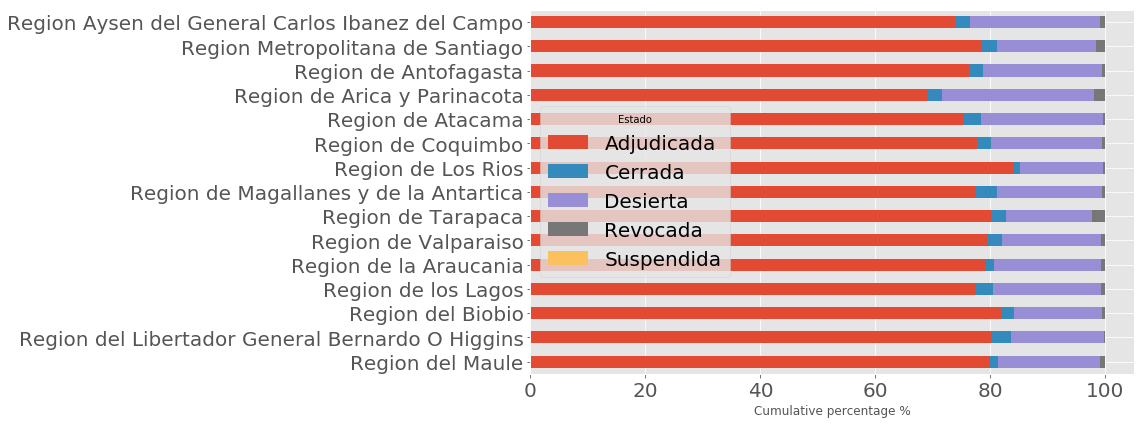

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1)

# distribution of tender states within regions
grouped_region_state = tender_df.groupby(['CompradorRegionUnidad', 'Estado']).size()
grouped_region_state = grouped_region_state.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()
grouped_region_state.sort_index(inplace=True, ascending=False)
_ = grouped_region_state.plot(kind='barh', stacked=True, figsize=(16, 6), ax=ax)
_ = ax.set_ylabel('')
_ = ax.set_xlabel('Cumulative percentage %')
plt.tight_layout()

### Construyendo los features

In [27]:
dataset = pd.merge(left=tprod_df, right=tender_df, on='CodigoExterno', how='left')

# remove all non Adjudicada nor Desierta tenders
dataset = dataset[(dataset['Estado'].isin(['Adjudicada', 'Desierta']))]

# create date features
dataset['time_duration_days'] = (dataset['FechasFechaCierre'] - dataset['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
dataset['time_est_decision_days'] = (dataset['FechasFechaEstimadaAdjudicacion'] - dataset['FechasFechaPublicacion']) / np.timedelta64(1, 'D')

# remove all date features
non_date_cols = list(filter(lambda colname: 'Fecha' not in colname, dataset.columns))
dataset = dataset[non_date_cols]

# remove all "code" features
code_exception = ['CodigoProducto', 'CodigoCategoria', 'CodigoTipo']
non_code_cols = list(filter(lambda colname: colname in code_exception or 'Codigo' not in colname, dataset.columns))
dataset = dataset[non_code_cols]

# remove all email features
non_email_cols = list(filter(lambda colname: 'Email' not in colname, dataset.columns))
dataset = dataset[non_email_cols]

# remove rut features
non_rut_cols = list(filter(lambda colname: 'Rut' not in colname, dataset.columns))
dataset = dataset[non_rut_cols]

# remove all post-adjudicacion features
adj_exception = ['CompradorRegionUnidad']
non_adj_cols = list(filter(lambda colname: colname in adj_exception or 
                           not ('Comprador' in colname or 'Adjudicacion' in colname), dataset.columns))
dataset = dataset[non_adj_cols]

# remove name features
non_name_cols = list(filter(lambda colname: 'Nombre' not in colname, dataset.columns))
dataset = dataset[non_name_cols]

# remove direction features
non_dir_cols = list(filter(lambda colname: 'Direccion' not in colname, dataset.columns))
dataset = dataset[non_dir_cols]

# remove ad hocs
to_remove = ['Descripcion', 'Categoria', 'Tipo', 'NombreProducto', 
             'TomaRazon', 'Descripcion_x', 'Descripcion_y', 'FonoResponsableContrato',
            'EstadoEtapas', 'TipoConvocatoria', 'Correlativo']
non_remove_cols = list(filter(lambda colname: colname not in to_remove, dataset.columns))
dataset = dataset[non_remove_cols]

print(dataset.shape)

(72846, 42)


In [28]:
perc_null = dataset.apply(lambda x: x.isnull().sum() / x.shape[0] * 100, axis=0)
perc_null_df = pd.DataFrame.from_dict({'Column': dataset.columns, 'PercentageNull': perc_null})
perc_null_df.reset_index(drop=True, inplace=True)

### Remove all columns with percentage null more than 50%

In [29]:
threshold = 50
for col in dataset.columns:
    perc_null = perc_null_df.loc[(perc_null_df['Column'] == col), 'PercentageNull'].values
    assert len(perc_null) == 1
    perc_null = perc_null[0]
    if perc_null > threshold:
        dataset.drop(labels=col, inplace=True, axis=1)

### Remove all columns with 0 variation, i.e., 0 variance

In [30]:
for col in dataset.columns:
    if dataset[col].unique().shape[0] == 1:
        dataset.drop(col, axis=1, inplace=True)

### Normalize data

In [31]:
def normalize_col(col):
    if not np.issubdtype(col.dtype, np.number):
        return col
    return (col - col.min()) / (col.max() - col.min())

dataset_norm = dataset.apply(normalize_col, axis=0)

### Encode the non numerical columns

In [32]:
from sklearn import preprocessing

le_dict = dict()
for col in dataset_norm.columns:
    if np.issubdtype(dataset_norm[col].dtype, np.number):
        continue
    # take care of nan values
    dataset_norm[col].fillna(value=str(np.nan), inplace=True)
    le = preprocessing.LabelEncoder()
    # fit the labels
    _ = le.fit(dataset_norm[col])
    # transform the labels
    dataset_norm[col] = le.transform(dataset_norm[col])
#    print(le.inverse_transform(dataset[col]))
    # save the labeler
    le_dict[col] = le

### Remove columns that have too low of a variance

In [33]:
var_threshold = .01
for col in dataset_norm.columns:
    if dataset_norm[col].var() < var_threshold:
        dataset_norm.drop(col, axis=1, inplace=True)

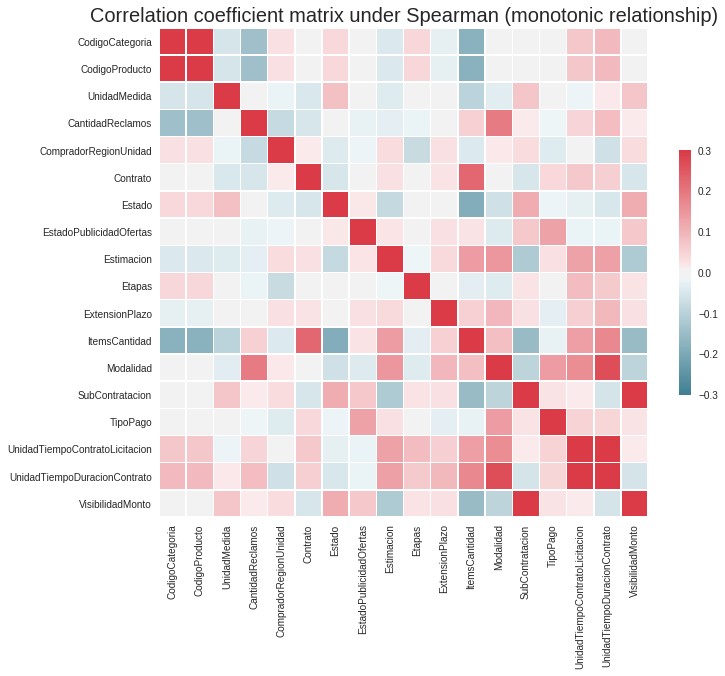

In [34]:
import seaborn as sns

corr = dataset_norm.corr('spearman')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

_ = ax.set_title('Correlation coefficient matrix under Spearman (monotonic relationship)', fontsize=20)

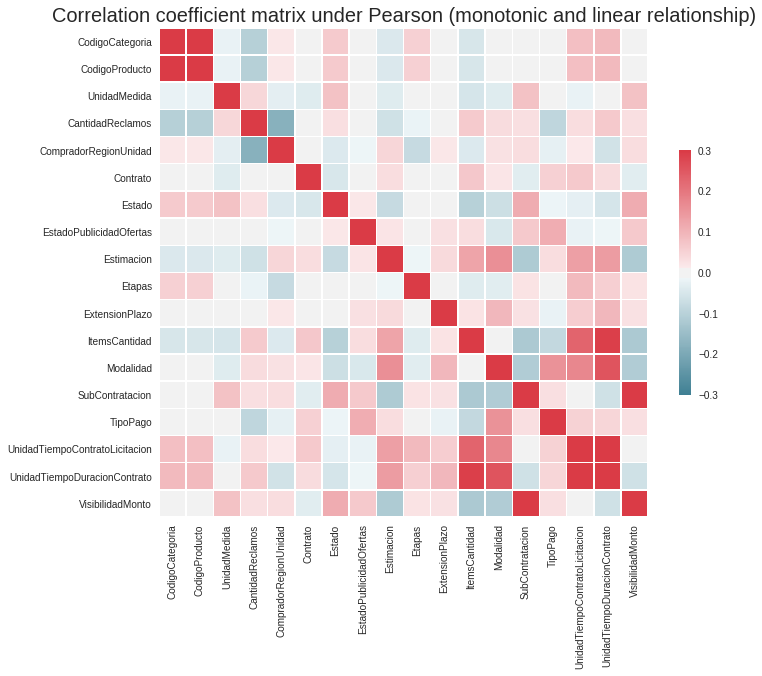

In [35]:
corr = dataset_norm.corr('pearson')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

_ = ax.set_title('Correlation coefficient matrix under Pearson (monotonic and linear relationship)', fontsize=20)

Calculamos los coeficientes de correlacion de los features eligidos y obtenemos resultados bastante interesantes. Por el tema de espacio, solamente presentamos los siguientes puntos claves:

- Los valores de Spearman son mas alto que de Pearson. Esto significa que muchas de las correlaciones no son lineales y implicando que seria mejor usar modelos no lineales como SVM (por projeccion de dimensiones a traves del uso de kernels) y decision tree.
- Codigo Producto y Codigo Categoria son altamente correlacionado y de hecho son casi lo mismo con respeto a los otros features. Eso implica que son casi lo mismo pero tambien indica que quizas las organizaciones publicas no estan usando el sistema de clasificacion bien. Podemos asumir que el sistema es muy bueno porque viene de UNICEF y esta implementado todo el mundo. La idea de un sistema de clasificacion es para categorizar cosas y el dato muestra que no esta haciendo esto. Vemos la razon mas adelante con el tema de agrupacion de productos de licitaciones.
- Para predecir si una licitacion va a ser adjudicada o no, los tres features principales son time_duration_days (i.e., por cuanto tiempo esta abierta para postular la licitacion) y UnidadTiempoContratoLicitacion (i.e., si el contrato es de dias, meses o anos) y Informada (creemos que este feature significa si el publico va a ser informado sobre la licitacion).
- Hay una zona de alta correlacion sobre la duracion del contracto y la duracion de la licitacion.
- La CompradorRegionUnidad (i.e., region) tiene correlacion con ItemsCantidad (el numero de productos en una licitacion). Esto implica quizas hay distinto comportamiento entre distintas regiones.

### Elimina mas features

In [36]:
to_remove = ['CodigoCategoria', 'Obras', 'CodigoTipo', 'time_est_decision_days',
            'UnidadTiempoEvaluacion', 'UnidadTiempoDuracionContrato', 
            'Contrato', 'Etapas', 'ExtensionPlazo', 'Moneda']
non_remove = [col for col in dataset_norm.columns if col not in to_remove]
dataset_norm = dataset_norm[non_remove]

### Evaluamos con clasificadores

In [37]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

'''
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
'''
names = ["Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
#    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

'\nnames = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",\n         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",\n         "Naive Bayes", "QDA"]\n'

### Distribution of target (Adjudicacion)

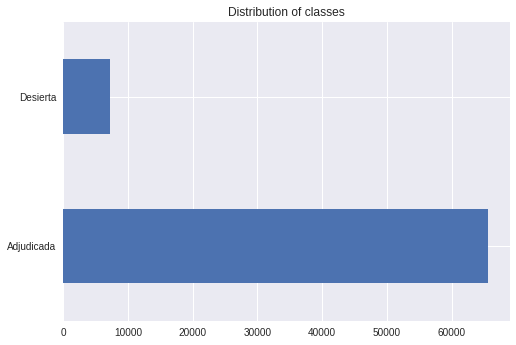

In [38]:
grouped = dataset_norm.groupby('Estado').size()
grouped.index = le_dict['Estado'].inverse_transform(grouped.index.values)
ax = grouped.plot(kind='barh')
_ = ax.set_title('Distribution of classes')

Vamos a usar oversampling con el train set.

### Create train and test sets

In [39]:
dataset_y = dataset_norm['Estado']
dataset_X = dataset_norm.drop('Estado', axis=1)

train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, test_size=.4, random_state=123)

# there can be overlap between train and test sets where there are instances duplicated in both train and test
# for fairer test, remove those from test
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)
before = test.shape[0]

merged = pd.merge(test, train, how='outer', indicator=True)
# select only left_only, i.e., unique test set instances
test_no_dup = merged.loc[merged._merge=='left_only']
test_no_dup.drop('_merge', inplace=True, axis=1)
after = test_no_dup.shape[0]
print('Removed {} rows from test set with original: {}'.format(before - after, before))
print('Removed {:.2f}% of original'.format((before - after) / before * 100))

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# oversample train set
grouped = train.groupby('Estado').size()
to_oversample = int(abs(grouped.diff()[1]))
print('Oversampling {} rows...'.format(to_oversample))
le = le_dict['Estado']
idx = np.random.choice(train.loc[train['Estado'] == le.transform(['Desierta'])[0]].index, size=to_oversample)
train_oversampled = pd.concat([train, train.iloc[idx]])

train_ds_list = [train, train_oversampled]
train_ds_namelist = ['Original', 'Oversampled']

test_ds_list = [test, test_no_dup]
test_ds_namelist = ['Original', 'No duplicates']


Removed 14647 rows from test set with original: 29139
Removed 50.27% of original
Oversampling 35235 rows...


In [40]:
import multiprocessing
from multiprocessing import Queue
import math
import functools as fct

In [41]:
# parallelize at the level of classifiers
def mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs):
    def worker(train_X, train_y, test_X, test_y, name_list, clf_list, out_q):
        '''
        The worker function, invoked in a process. 
        '''
        outdict = {}
        for name, clf in zip(name_list, clf_list):
            # train and test classifier
            print('Training {}...'.format(name))
            clf.fit(train_X, train_y)
            print('Testing {}...'.format(name))
            y_pred = clf.predict(test_X)
            scores = precision_recall_fscore_support(y_pred=y_pred, y_true=test_y)
            score_list = list(zip([name for _ in range(len(scores[0]))], clf.classes_,
                                 scores[0], scores[1], scores[2], scores[3]))
            # put report to dict
            outdict[name] = score_list
        # put to out_q
        out_q.put(outdict)
        
    # Each process wil get 'chunksize' clfs and a queue to put the outdict in
    out_q = Queue()
    chunksz = int(math.ceil(len(classifiers) / float(nprocs)))
    procs = []
    
    for i in range(nprocs):
        start = chunksz * i
        end = chunksz * (i + 1)
        p = multiprocessing.Process(
                target=worker,
                args=(train_X, train_y, test_X, test_y, 
                      names[start:end], classifiers[start:end], out_q))
        procs.append(p)
        p.start()
    
    # Collect all results into a single result dict
    resultdict = dict()
    for i in range(nprocs):
        outdict = out_q.get()
        resultdict.update(outdict)
    # turn resultdict to dataframe
    # print(list(resultdict.values()))
    values = fct.reduce(lambda l, x: l + x, list(resultdict.values()))
    values = list(zip(*values))
    value_dict = {'clf': values[0], 'class': values[1],
                'precision': values[2], 'recall': values[3],
                'f1': values[4], 'support': values[5]}
    result_df = pd.DataFrame(value_dict)
        
    # wait for all worker processes to finish
    for p in procs: 
        p.join()
    
    return result_df

In [42]:
le = le_dict['Estado']
target_names = le.inverse_transform([0, 1])
nprocs = multiprocessing.cpu_count()
# print(nprocs)

result_df = pd.DataFrame()
for train_ds_name, train_ds in zip(train_ds_namelist, train_ds_list):
    train_X = train_ds.drop('Estado', axis=1)
    train_y = train_ds['Estado']
    # print('Training on {} dataset'.format(train_ds_name))
    
    for test_ds_name, test_ds in zip(test_ds_namelist, test_ds_list):
        test_X = test_ds.drop('Estado', axis=1)
        test_y = test_ds['Estado']
        # los experimentos fueron realizados en otro computador, solamente importamos los resultados
        '''
        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)
        # columns about train and test set
        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]
        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]
        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]
        if result_df.empty:
            result_df = out_df
        else:
            result_df = pd.concat([result_df, out_df], axis=0)


outdir = '.' + os.sep + 'out'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
result_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)
'''

result_df = pd.read_csv('.' + os.sep + 'out' + os.sep + 'classificationResult.csv')

"\n        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)\n        # columns about train and test set\n        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]\n        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]\n        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]\n        if result_df.empty:\n            result_df = out_df\n        else:\n            result_df = pd.concat([result_df, out_df], axis=0)\n\n\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

"\n        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)\n        # columns about train and test set\n        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]\n        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]\n        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]\n        if result_df.empty:\n            result_df = out_df\n        else:\n            result_df = pd.concat([result_df, out_df], axis=0)\n\n\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

"\n        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)\n        # columns about train and test set\n        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]\n        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]\n        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]\n        if result_df.empty:\n            result_df = out_df\n        else:\n            result_df = pd.concat([result_df, out_df], axis=0)\n\n\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

"\n        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)\n        # columns about train and test set\n        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]\n        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]\n        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]\n        if result_df.empty:\n            result_df = out_df\n        else:\n            result_df = pd.concat([result_df, out_df], axis=0)\n\n\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

Los experimentos fueron realizado en otro computador y importamos los resultados aqui. Tambien una nota: intentamos experimentar con los clasificadores SVM (lineal) y Gaussian Process. Pero SVM (lineal) era muy lento y Gaussian Process tiene memory error. Por lo tanto los quitamos.


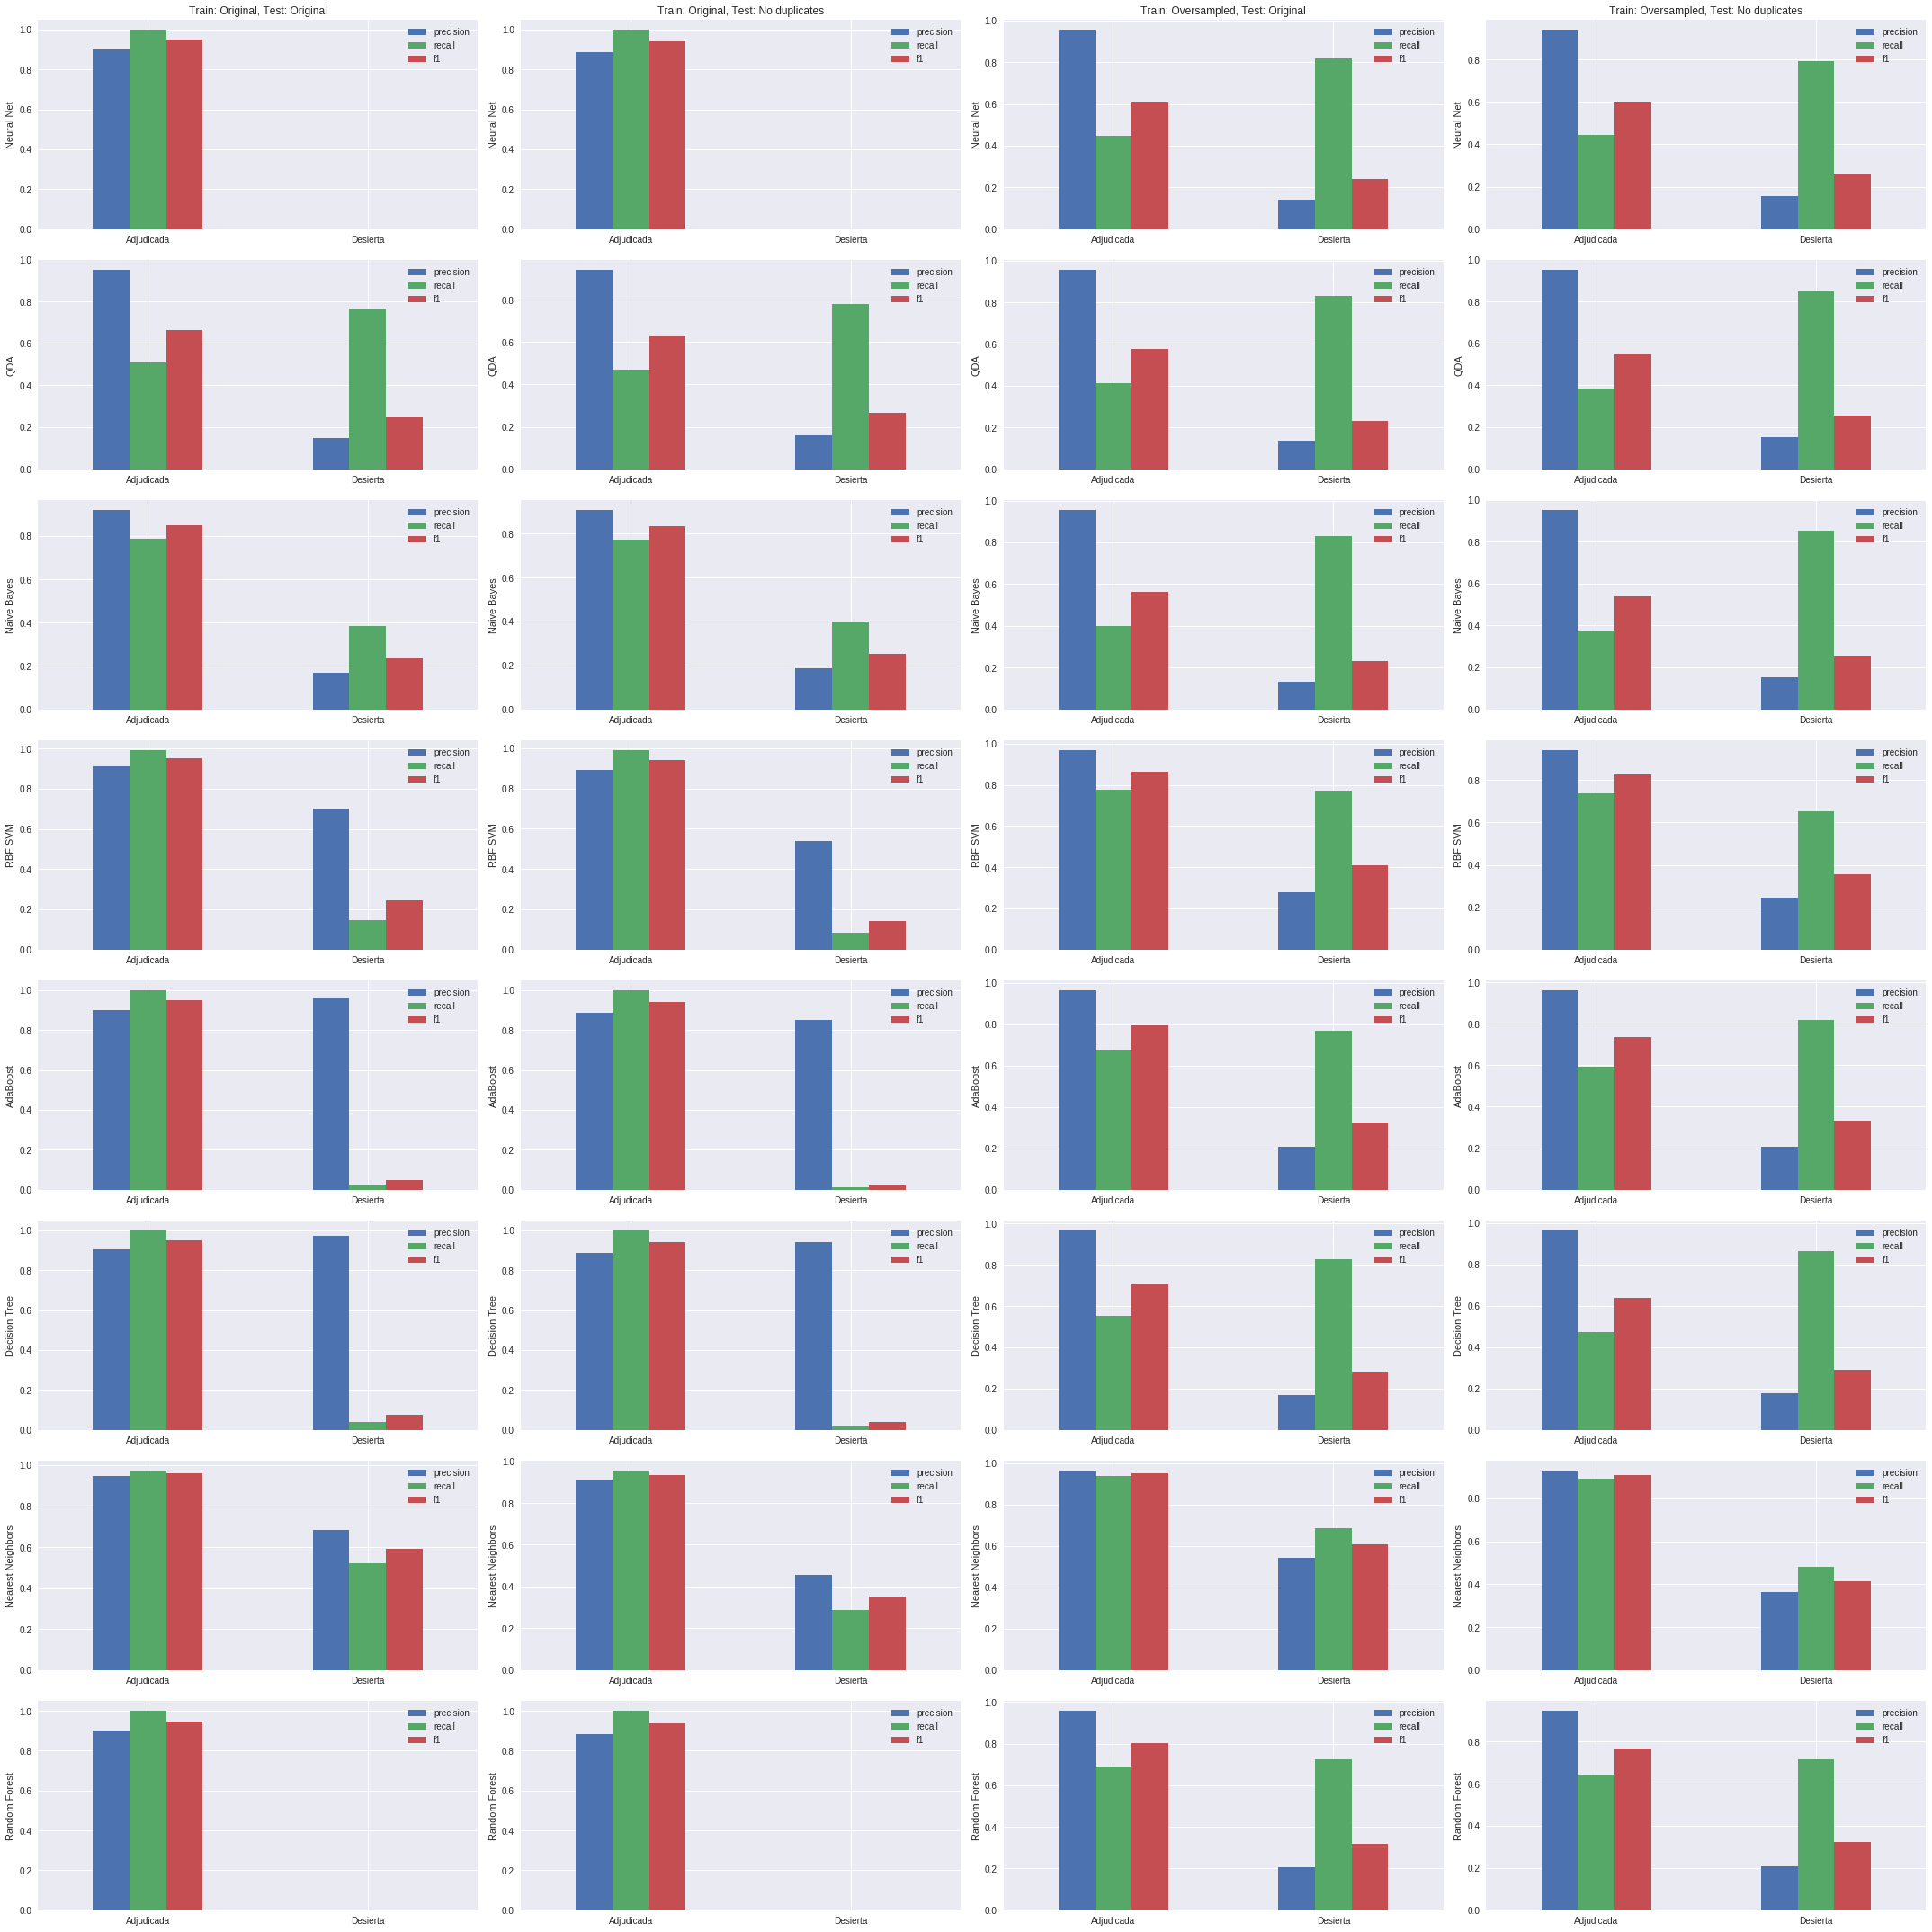

In [43]:
nrows = result_df.clf.unique().shape[0]
ncols = result_df[['train', 'test']].drop_duplicates().shape[0]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))

clfs = result_df.clf.unique()
train_test_pairs = result_df[['train', 'test']].drop_duplicates().values
state_le = le_dict['Estado']

for i in range(nrows):
    clf = clfs[i]
    clf_results = result_df[(result_df.clf == clf)]
    for j in range(ncols):
        train_test_pair = train_test_pairs[j]
        # print(train_test_pair)
        ax = axes[i, j]
        result = clf_results[(clf_results['train']==train_test_pair[0])&
                            (clf_results['test']==train_test_pair[1])]
        # print(result)
        _ = result[['precision', 'recall', 'f1']].plot(kind='bar', ax=ax, rot=0);
        
        if i == 0:
            _ = ax.set_title('Train: {}, Test: {}'.format(train_test_pair[0], train_test_pair[1]))
        _ = ax.set_ylabel('{}'.format(clf))
        _ = ax.set_xticklabels(state_le.inverse_transform(result['class']))
        
# plt.savefig('./classificationResult.png')
plt.tight_layout()

Podemos observar que en general es muchas mas facil clasificar una licitacion que va a ser adjudicada que clasificar una licitacion que va a ser desierta. Los resultados para clasificacion de licitaciones adjudicadas en general son buenos y con alto recall tambien. Pero si no hacemos oversampling con en train set, los resultados para clasificar una licitacion desierta es bastante malo.

Pero igual con oversampling, los resultados para clasificar una licitacion desierta no son tan buenos. Esto puede ser debido al hecho que la clase 'Adjudicada' tiene 39471 licitaciones y la clase 'Desierta' tiene 4236 licitaciones. Entonces estamos haciendo oversampling de 39471 - 4236 = 35235 instancias (repitiendo ~8 veces cada una de las 4236 licitaciones). Ademas una licitacion puede ser desierta por distintas razones y en estos modelos categorizamos todas las licitaciones desiertas en la misma clase.

Al final, parece que NearestNeighbour tiene el mejor rendimiento.

En la siguiente parte, vamos a moverse desde clasificacion a clustering con cual intentamos entender mas el dato antes de construir mas modelos predictivos.

### Clustering para entender relaciones entre distintas regiones y productos
Uno de los problemas es que no sabemos si el dato de distintas regiones y producto categorias es comparable. Es decir si una licitacion de la region Metropolitana es comparable con otra licitacion de la region Aysen. O si una licitacion que tiene Productos derivados de minerales plantas y animales es comparable con otra licitacion de Servicios de limpieza industrial. 
Para la tarea de clasificacion, podemos resolver el problem si convertimos los valores categoricos a valores numericos. 

Pero tanto una parte de reduccion de dimensionalidad como una pregunta de investigacion en si, intentamos de abordar esta pregunta usando clustering. Si las regiones son comparables, podemos juntar los datos de distintas region para entrenar un modelo comun pero si no tendriamos entrenar distintos modelos para distintas regiones.
La misma logica se aplica con categorias y productos.

### Numero de distintos tipos de productos y categorias por licitacion

In [44]:
tprod_df1 = tprod_df[['CodigoExterno', 'CodigoProducto', 'CodigoCategoria']].drop_duplicates()
grouped = tprod_df1.groupby('CodigoExterno', as_index=False)
grouped_tprod = grouped.agg({'CodigoProducto': pd.Series.nunique})
grouped_tprod.columns = ['CodigoExterno', 'num_of_prod_type']
grouped_cat = grouped.agg({'CodigoCategoria': pd.Series.nunique})
grouped_cat.columns = ['CodigoExterno', 'num_of_cat_type']

tprod_df1 = pd.merge(tprod_df1, grouped_tprod, how='left', on='CodigoExterno')
tprod_df1 = pd.merge(tprod_df1, grouped_cat, how='left', on='CodigoExterno')

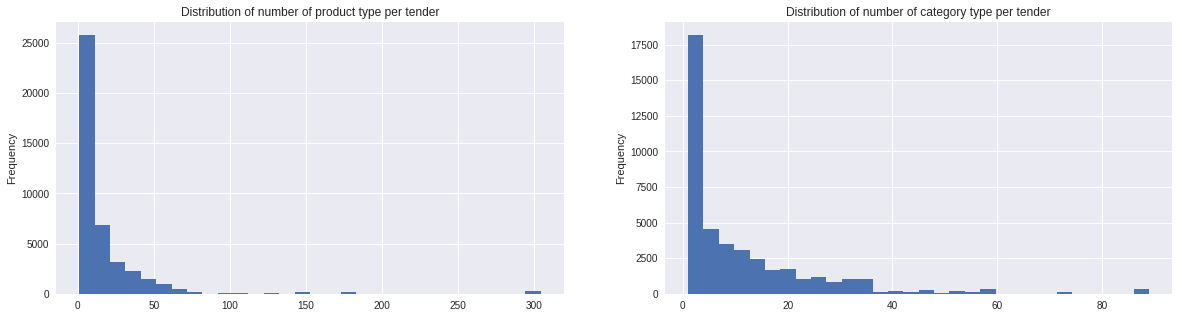

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

_ = tprod_df1['num_of_prod_type'].plot.hist(ax=axes[0], bins=30)
_ = axes[0].set_title('Distribution of number of product type per tender')

_ = tprod_df1['num_of_cat_type'].plot.hist(ax=axes[1], bins=30)
_ = axes[1].set_title('Distribution of number of category type per tender')

Podemos ver que existe licitaciones que tiene mas que un tipo de productos o categorias por ejemplo: 3334-90-LR16 es una licitacion que tiene 304 distintos productos y 89 distintas categorias. Y tiene 21 proveedores. Entonces es una licitacion muy grande.

## Compute the total tender price and the tender price per product code

### Total tender price

In [46]:
# only sold tender products
tprod_df2 = tprod_df[(tprod_df.AdjudicacionCantidad.isnull() == False)]
# create new column which is sold quantity x sold price
tprod_df2['sold_price'] = tprod_df2.AdjudicacionCantidad * tprod_df2.AdjudicacionMontoUnitario
# groupby tender code
grouped_tender = tprod_df2.groupby('CodigoExterno', as_index=False)
total_tender_price = grouped_tender.agg({'sold_price': np.sum})
tender_sold_df = pd.merge(tender_df, total_tender_price, how='inner', on='CodigoExterno')

grouped_tprod = tprod_df2.groupby(['CodigoExterno', 'CodigoProducto']).agg({'sold_price': np.sum})
grouped_tprod = grouped_tprod.reset_index()
tprod_sold_df = pd.merge(grouped_tprod, tender_df, how='left', on='CodigoExterno')

In [47]:
num_tprods = tprod_sold_df.groupby('CodigoProducto').size().reset_index()
num_tprods.columns = ['CodigoProducto', 'frequency']
num_tprods.sort_values('frequency', ascending=False, inplace=True)
top_5_cats = num_tprods.CodigoProducto.values[:5]

### Analyse the top category

In [48]:
dataset = tprod_sold_df[(tprod_sold_df.CodigoProducto==top_5_cats[0])]

### Choosing the features to cluster

In [49]:
dataset['time_duration_days'] = (dataset['FechasFechaCierre'] - dataset['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
dataset['time_sale_days'] = (dataset['FechasFechaAdjudicacion'] - dataset['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
dataset['time_decision_days'] = (dataset['FechasFechaEstimadaAdjudicacion'] - dataset['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
dataset['time_estimation_error_days'] = (dataset['FechasFechaEstimadaAdjudicacion'] - dataset['FechasFechaAdjudicacion']) / np.timedelta64(1, 'D')


In [50]:
# remove all date features
non_date_cols = list(filter(lambda colname: 'Fecha' not in colname, dataset.columns))
dataset = dataset[non_date_cols]

# remove all "code" features
code_exception = ['CodigoProducto', 'CodigoCategoria', 'CodigoTipo']
non_code_cols = list(filter(lambda colname: colname in code_exception or 'Codigo' not in colname, dataset.columns))
dataset = dataset[non_code_cols]

# remove all email features
non_email_cols = list(filter(lambda colname: 'Email' not in colname, dataset.columns))
dataset = dataset[non_email_cols]

# remove rut features
non_rut_cols = list(filter(lambda colname: 'Rut' not in colname, dataset.columns))
dataset = dataset[non_rut_cols]

# remove all post-adjudicacion features
adj_exception = ['CompradorRegionUnidad']
non_adj_cols = list(filter(lambda colname: colname in adj_exception or 
                           not ('Comprador' in colname or 'Adjudicacion' in colname), dataset.columns))
dataset = dataset[non_adj_cols]

# remove name features
non_name_cols = list(filter(lambda colname: 'Nombre' not in colname, dataset.columns))
dataset = dataset[non_name_cols]

# remove direction features
non_dir_cols = list(filter(lambda colname: 'Direccion' not in colname, dataset.columns))
dataset = dataset[non_dir_cols]

# remove ad hocs
to_remove = ['Descripcion', 'Categoria', 'Tipo', 'NombreProducto', 
             'TomaRazon', 'Descripcion_x', 'Descripcion_y', 'FonoResponsableContrato',
            'EstadoEtapas', 'TipoConvocatoria', 'Correlativo', 'FuenteFinanciamiento']
non_remove_cols = list(filter(lambda colname: colname not in to_remove, dataset.columns))
dataset = dataset[non_remove_cols]

print(dataset.shape)

(335, 41)


### Remove all columns with percentage null more than 50%

In [51]:
perc_null = dataset.apply(lambda x: x.isnull().sum() / x.shape[0] * 100, axis=0)
perc_null_df = pd.DataFrame.from_dict({'Column': dataset.columns, 'PercentageNull': perc_null})
perc_null_df.reset_index(drop=True, inplace=True)

threshold = 50
for col in dataset.columns:
    perc_null = perc_null_df.loc[(perc_null_df['Column'] == col), 'PercentageNull'].values
    assert len(perc_null) == 1
    perc_null = perc_null[0]
    if perc_null > threshold:
        dataset.drop(labels=col, inplace=True, axis=1)

### Remove all columns with 0 variation, i.e., 0 variance

In [52]:
for col in dataset.columns:
    if dataset[col].unique().shape[0] == 1:
        dataset.drop(col, axis=1, inplace=True)

### Normalize numerical values

In [53]:
def normalize_col(col):
    if not np.issubdtype(col.dtype, np.number):
        return col
    return (col - col.min()) / (col.max() - col.min())

dataset_norm = dataset.apply(normalize_col, axis=0)

### Encode the non numerical columns

In [54]:
from sklearn import preprocessing

le_dict = dict()
for col in dataset_norm.columns:
    if np.issubdtype(dataset_norm[col].dtype, np.number):
        continue
    # take care of nan values
    dataset_norm[col].fillna(value=str(np.nan), inplace=True)
    le = preprocessing.LabelEncoder()
    # fit the labels
    _ = le.fit(dataset_norm[col])
    # transform the labels
    dataset_norm[col] = le.transform(dataset_norm[col])
#    print(le.inverse_transform(dataset[col]))
    # save the labeler
    le_dict[col] = le

### Remove features with low variance

In [55]:
var_threshold = .01
for col in dataset_norm.columns:
    if dataset_norm[col].var() < var_threshold:
        dataset_norm.drop(col, axis=1, inplace=True)

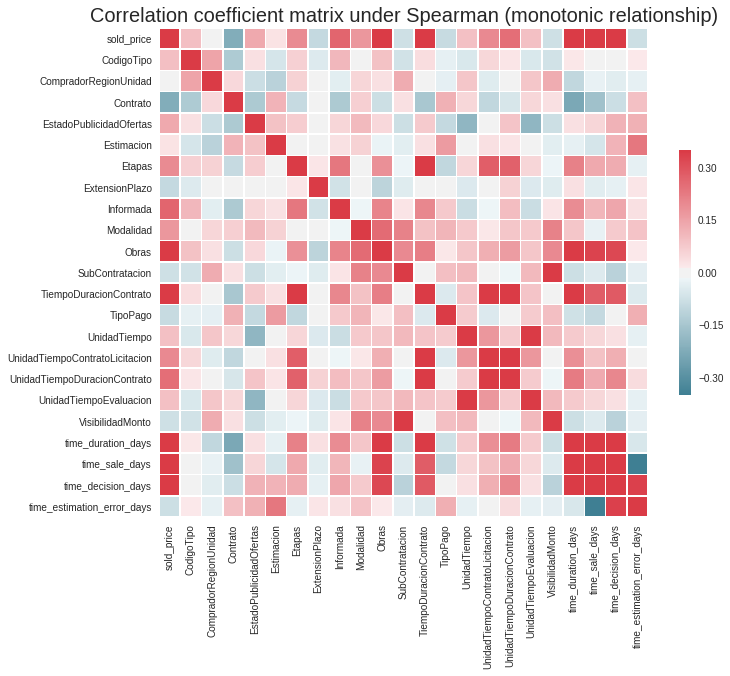

In [56]:
import seaborn as sns

corr = dataset_norm.corr('spearman')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

_ = ax.set_title('Correlation coefficient matrix under Spearman (monotonic relationship)', fontsize=20)

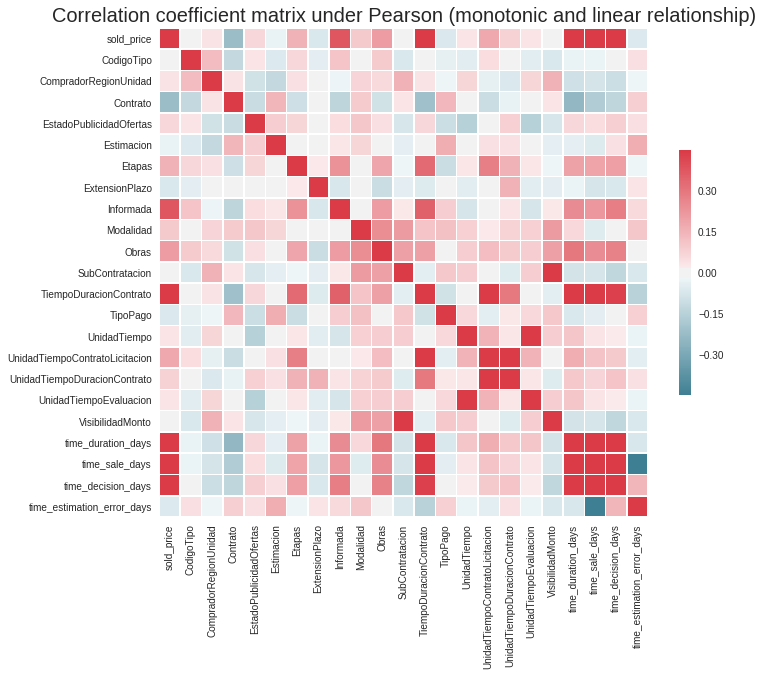

In [57]:
corr = dataset_norm.corr('pearson')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

_ = ax.set_title('Correlation coefficient matrix under Pearson (monotonic and linear relationship)', fontsize=20)

In [58]:
from scipy.cluster.hierarchy import dendrogram, linkage

## KMeans clustering 

### Estimate k

In [59]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


In [60]:
cluster_dataset = dataset_norm.loc[:,~(dataset_norm.isnull().any())]
maxK = 20
sse_list = np.zeros(maxK)
# number of different initial centroids
n_init = 20
# number of cpus
n_jobs = -1
for i in range(maxK):
    k = i + 1
    # compute clustering
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=n_init, n_jobs=n_jobs).fit(cluster_dataset)
    # get the sse from kmeans
    sse_list[i] = kmeans.inertia_

In [61]:
sse_zip = list(zip(*enumerate(sse_list)))
sse_dict = {'k': sse_zip[0],
           'sse': sse_zip[1]}
sse_df = pd.DataFrame(sse_dict)
sse_df.k = sse_df.k.apply(lambda x: x + 1)

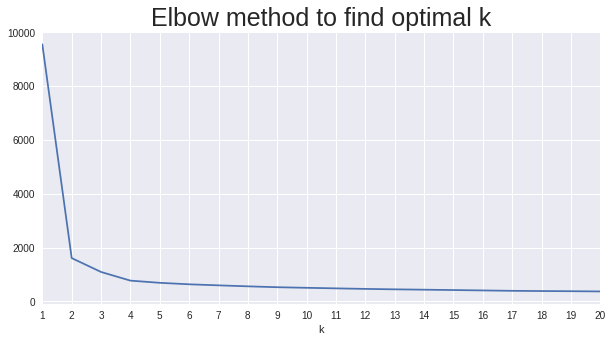

In [62]:
sse_df.set_index(sse_df.k, inplace=True)
ax = sse_df.sse.plot(xticks=sse_df.index, figsize=(10, 5))
_ = ax.set_title('Elbow method to find optimal k', fontsize=25)

## Visualize with pairplot

In [63]:
op_k = 2
n_init = 20
n_jobs = -1

kmeans = KMeans(n_clusters=op_k, n_init=n_init, n_jobs=n_jobs).fit(cluster_dataset)
# add the assigned classes to result
result = cluster_dataset.copy(deep=True)
result['label'] = kmeans.labels_

It seems to show that optimal k is 2.

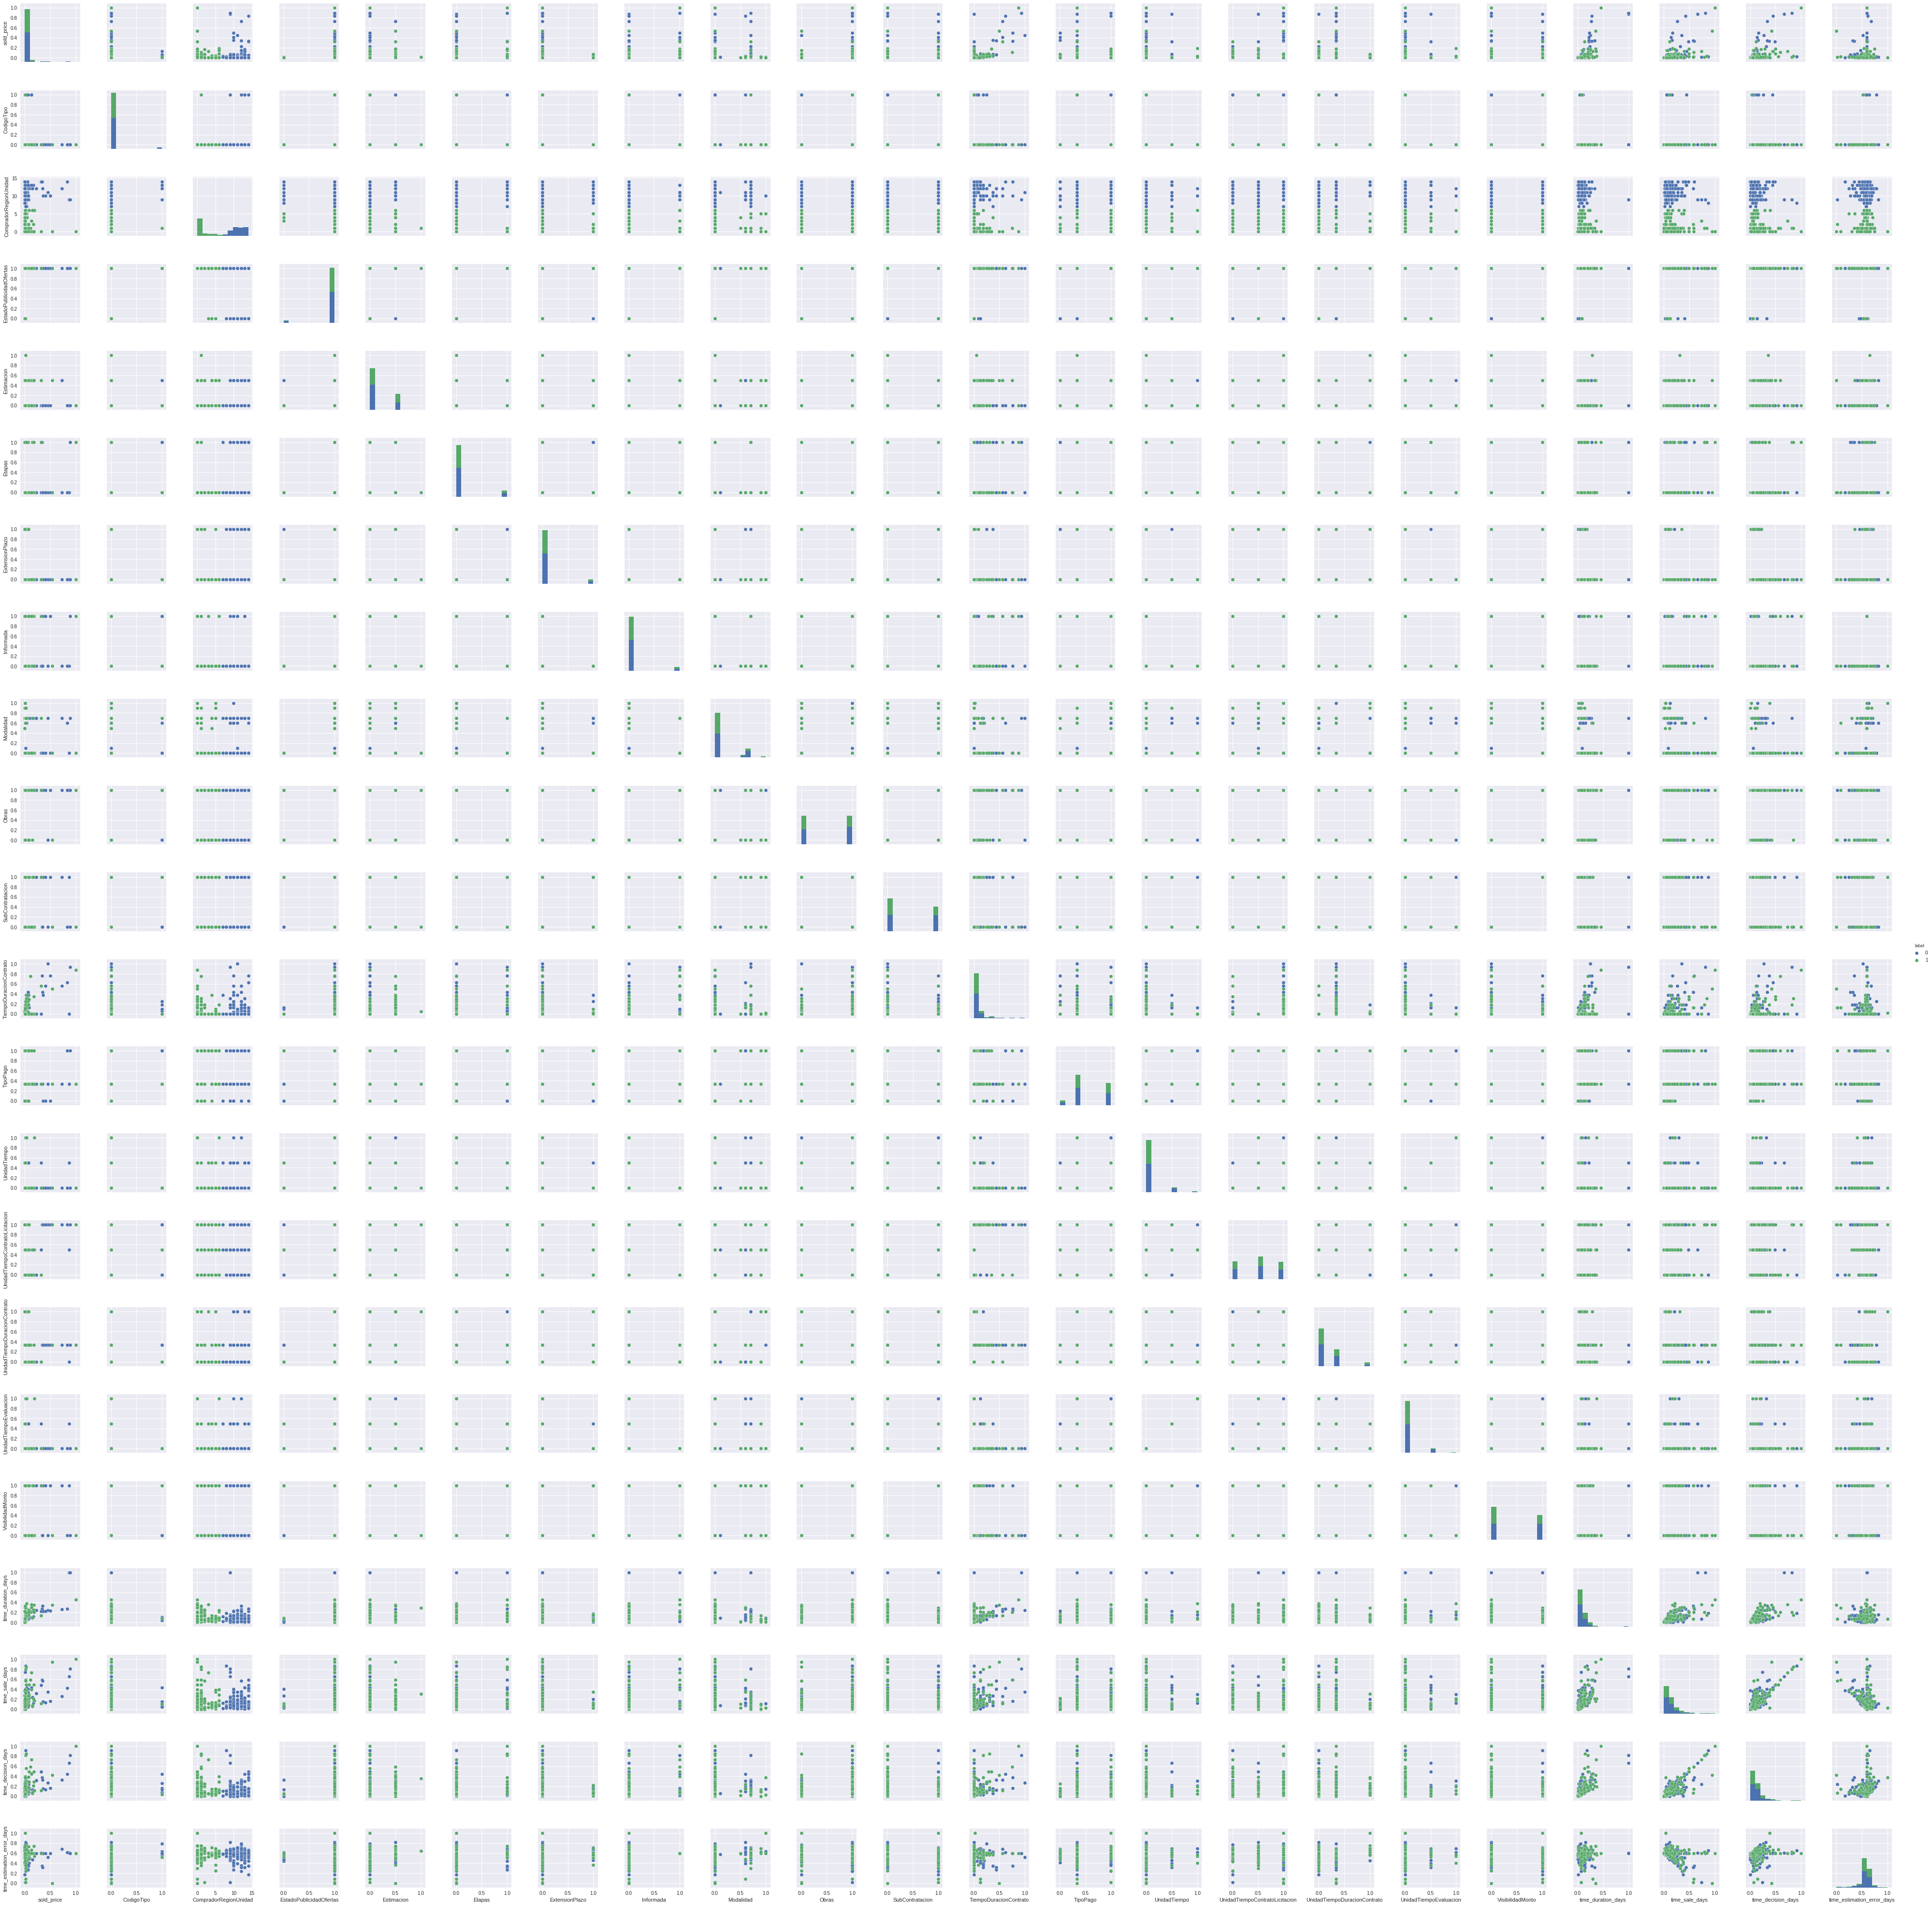

In [64]:
to_plot = [col for col in result.columns if col != 'label']
ax = sns.pairplot(data=result, x_vars=to_plot, y_vars=to_plot, hue='label')

Cluster separation seems to be at region level. Find out which regions belong to which cluster.

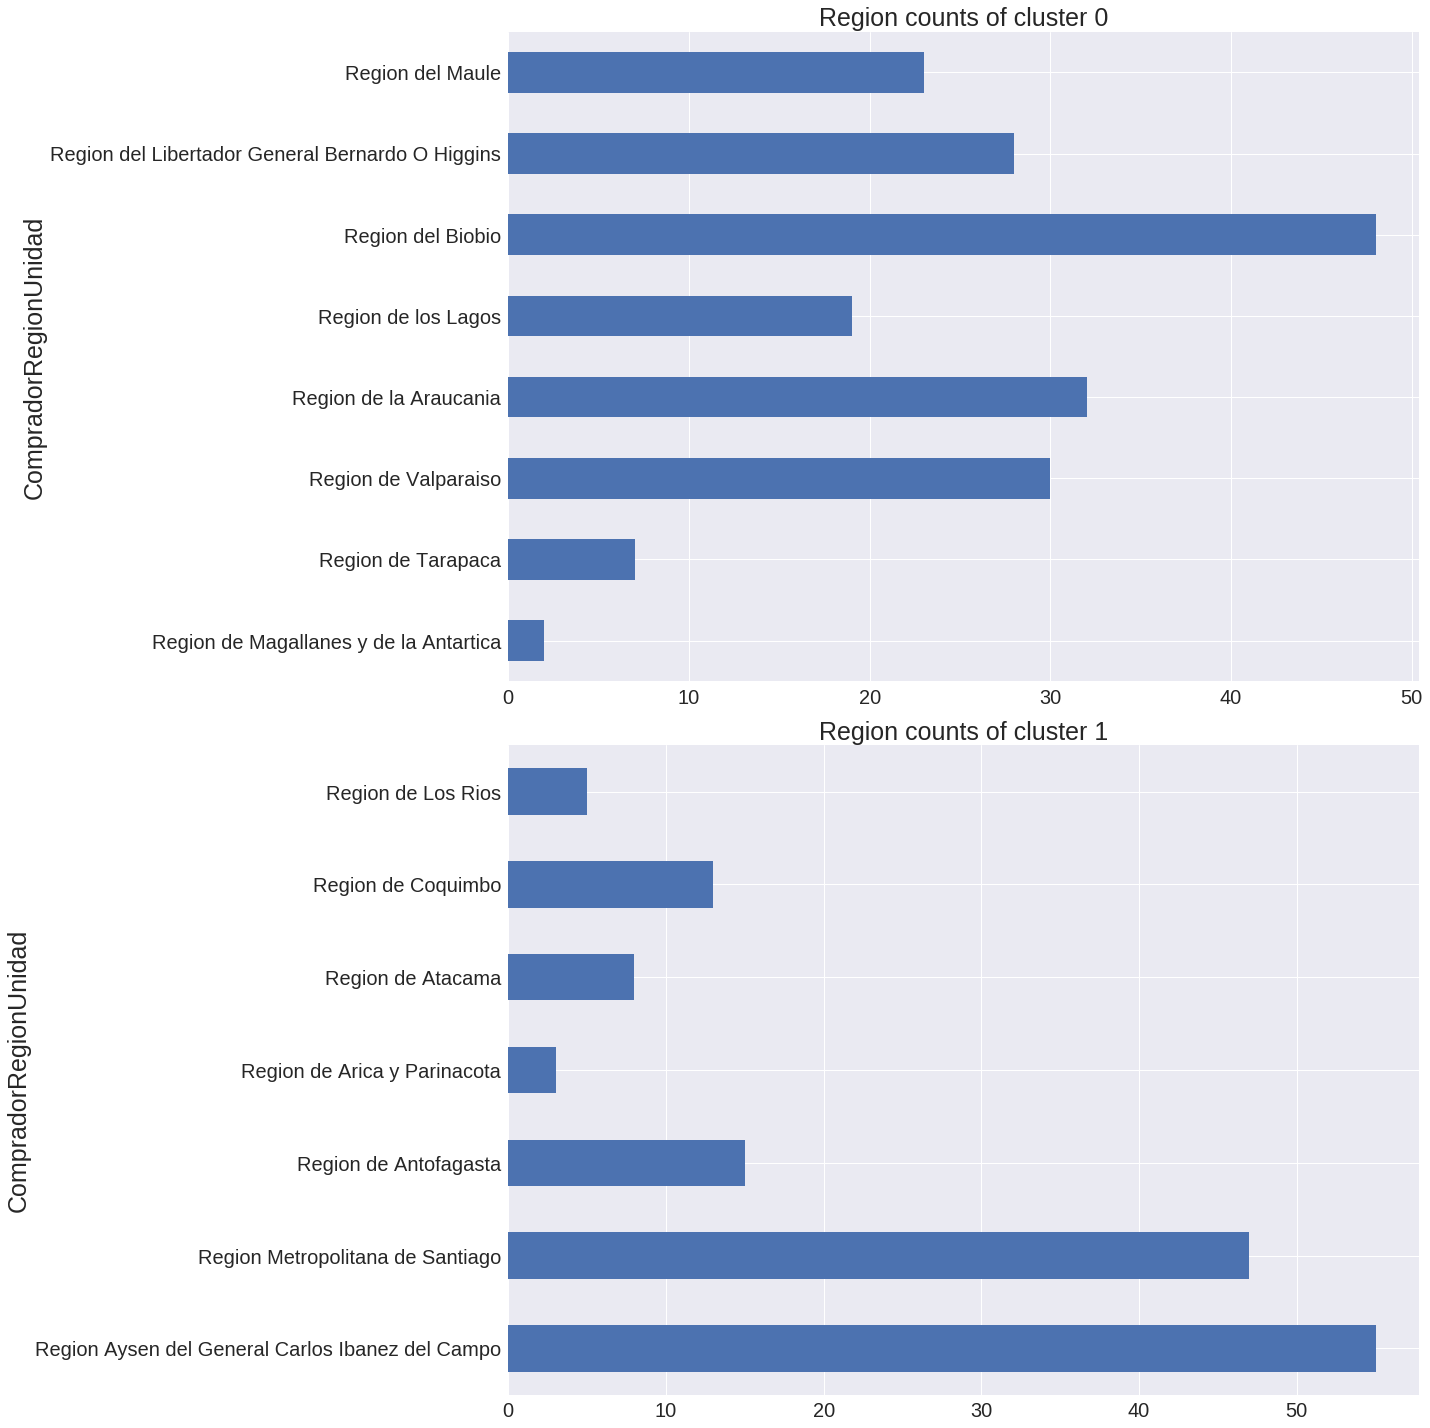

In [65]:
le_region = le_dict['CompradorRegionUnidad']
grouped_region = result.groupby('label')
label_0 = grouped_region.get_group(0)
label_1 = grouped_region.get_group(1)

label_0.CompradorRegionUnidad = le_region.inverse_transform(label_0.CompradorRegionUnidad.values)
label_1.CompradorRegionUnidad = le_region.inverse_transform(label_1.CompradorRegionUnidad.values)

fig, axes = plt.subplots(nrows=2, figsize=(20, 20))

grouped_label_0 = label_0.groupby('CompradorRegionUnidad').size()
_ = grouped_label_0.plot.barh(ax=axes[0])
_ = axes[0].tick_params(labelsize=20)
_ = axes[0].set_ylabel(axes[0].get_ylabel(), fontsize=25)
_ = axes[0].set_title('Region counts of cluster 0', fontsize=25)

grouped_label_1 = label_1.groupby('CompradorRegionUnidad').size()
_ = grouped_label_1.plot.barh(ax=axes[1])
_ = axes[1].tick_params(labelsize=20)
_ = axes[1].set_ylabel(axes[1].get_ylabel(), fontsize=25)
_ = axes[1].set_title('Region counts of cluster 1', fontsize=25)

plt.tight_layout()

While further evaluation is necessary, the two clusters seem to be of two groups of regions. It could also be because it was the easiest to cluster on.

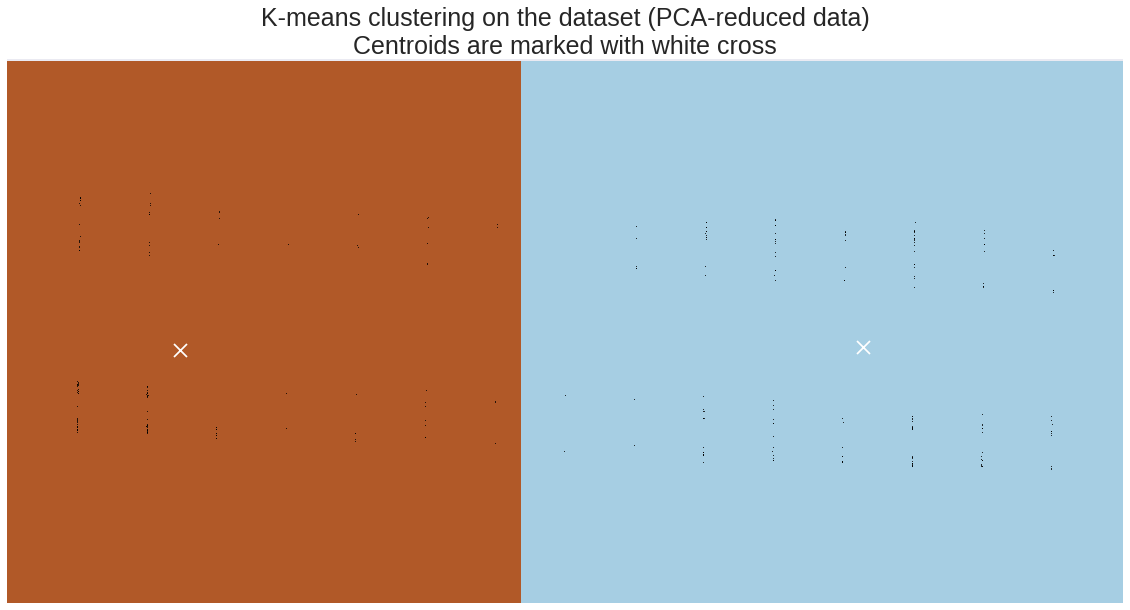

In [66]:
# #############################################################################
# Visualize the results on PCA-reduced data
op_k = 2
n_init = 20
n_jobs = -1

reduced_data = PCA(n_components=2).fit_transform(cluster_dataset)
kmeans = KMeans(init='k-means++', n_clusters=op_k, n_init=n_init, n_jobs=n_jobs)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

ax.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
ax.set_title('K-means clustering on the dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross', fontsize=25)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(());

# Conclusiones

### En resumen, para este Hito 2 hemos realizado lo siguiente:
- explicamos los feedback que recibimos y explicamos punto por punto que hicimos sobre los feedbacks
- encontramos algunos errores por la parte del dataset y tuvimos que re-procesar el dataset para arreglar los errores.
- a traves un metodo replicable y incremental, podiamos eligir features para dos tareas de data mining. En la reduccion de dimensionalidad, el enfoque fue mirando correlacion coeficiente, la porcentaje de NaN valores, semantica y la varianza en valores de features.
- realizamos $\textbf{clasificacion}$ para clasificar si una licitacion va a ser adjudicada o no.
- realizamos $\textbf{clustering}$ para cluster las licitaciones del top producto.

# Direcciones futuras

Dado el problema de la calidad de datos, vamos a enfocar en mas alto nivel, i.e., quizas no analizamos por producto de licitacion. Por ejemplo, podemos agrupar las licitaciones por region y haz analisis acerca regiones.

Ademas dado los resultados de las correlaciones coeficientes, vamos a investigar los features de tiempo.

Al final vamos a seguir con clustering, aplicando distintos tipos de clustering, por ejemplo clustering jerárquico. 

# Hito 3

### Resumen de feedback
- No esta clara la relacion entre el objetivo de la investigacion y los experimentos
Se puede mejorar con:
- Aclarar el objetivo de la investigacion y de los experimentos
- Mostrar ejemplos reales

# E1: Clasificar trazas de licitaciones
### Tender sale as quality criteria
~20% of the tenders are deserted for various reasons, e.g., no offers. This means ~3000 tenders and ~7000 tender products are not sold. However, what happens to the deserted tenders? Investigation shows that public organizations actually can republish the same tender. As such, $\textit{tender traces}$ can occur where each item of the tender trace is an individual tender. Some trace actually ends with a tender that is sold. 
For example: (example where tender trace ends with a sold tender, explain that the company who bid could not have been created in 18 days)

### Research questions
- What characteristics do traces that end with sold state?

### Experiment design
- Classification to classify these different types of traces
- Clustering

### Preprocessing
1. Remove columns with >90% null values or 0 variance
2. Remove tenders with 1 tender product
3. Get deserted tenders
4. Do not consider tenders related to hospital and health because of granularity issues, many times there are such big variances in product of the same product code that make it difficult to differentiate one tender product from other without looking into the contract.
5. For all the deserted tenders, find similar tenders by the tender name and organization.
6. Filter tender traces by validating the tender products and tender publication and close dates

In [67]:
# get the dfs from 2016
tender_df_list = list()
tprod_df_list = list()

for f in os.listdir('./data/processed2016/'):
    if 'tsmall' in f:
        tender_df_list.append(f)
    else:
        tprod_df_list.append(f)
        
tender_df_list = sorted(tender_df_list)
tprod_df_list = sorted(tprod_df_list)

print(tender_df_list)
print(tprod_df_list)

tender_df_list = [pd.read_csv(os.path.join('./data/processed2016/', df)) for df in tender_df_list]
tprod_df_list = [pd.read_csv(os.path.join('./data/processed2016/', df)) for df in tprod_df_list]

['tsmall01.csv', 'tsmall02.csv', 'tsmall03.csv', 'tsmall04.csv', 'tsmall05.csv', 'tsmall06.csv', 'tsmall07.csv', 'tsmall08.csv', 'tsmall09.csv', 'tsmall10.csv', 'tsmall11.csv', 'tsmall12.csv']
['tsprod01.csv', 'tsprod02.csv', 'tsprod03.csv', 'tsprod04.csv', 'tsprod05.csv', 'tsprod06.csv', 'tsprod07.csv', 'tsprod08.csv', 'tsprod09.csv', 'tsprod10.csv', 'tsprod11.csv', 'tsprod12.csv']


In [68]:
for df in tender_df_list:
    df.FechasFechaPublicacion = pd.to_datetime(df.FechasFechaPublicacion)
    df.sort_values('FechasFechaPublicacion', ascending=True, inplace=True)

## Getting the deserted tender traces of length > 1
### Get deserted tenders

In [69]:
def get_deserted(tender_df):
    tdesert_df = tender_df[
        (tender_df['Estado'].str.lower().str.startswith('desier'))
    ]
    return tdesert_df

desert_df_list = list()
for tender_df in tender_df_list:
    desert_df = get_deserted(tender_df)
    desert_df_list.append(desert_df)

### Getting the tender traces as described previously

In [70]:
def get_small_desert(tdesert_df):
    # the following organizations have low quality description in their tenders, basically they use the same tender name 
    # for the majority of their tenders
    excl_org_code = [7326, 87901]
    # some examples that did not make sense and therefore excluded
    excl_tid = ['3928-78-L116', '3928-82-L116', '3477-236-L116', '3477-241-L116',
               '2409-878-L116', '2409-910-L116']

    deserted = tdesert_df[
        ~(tdesert_df['CompradorCodigoOrganismo'].isin(excl_org_code))&
        ~(tdesert_df['CompradorNombreOrganismo'].str.lower().str.startswith('hospital'))&
        ~(tdesert_df['CompradorNombreOrganismo'].str.lower().str.contains('salud'))&
        ~(tdesert_df['CodigoExterno'].isin(excl_tid))
    ][['CodigoExterno', 'Nombre', 'FechasFechaPublicacion', 'FechasFechaCierre', 'CompradorCodigoOrganismo']].sort_values('FechasFechaPublicacion')
    return deserted

def get_similar_tenders(tender_df, deserted):
    similar_df = pd.DataFrame()
    checked = list()
    for td in deserted.itertuples():
        # check if this tender has been checked already
        if [td.CompradorCodigoOrganismo, td.Nombre] in checked:
            continue
        checked.append([td.CompradorCodigoOrganismo, td.Nombre])
        # identify similar tenders
        similar = tender_df[
            (tender_df['CompradorCodigoOrganismo']==td.CompradorCodigoOrganismo)&
            (tender_df['Nombre']==td.Nombre)
        ].sort_values('FechasFechaPublicacion')[['Estado', 'FechasFechaPublicacion', 'FechasFechaCierre', 'Nombre',
                                                 'CompradorNombreOrganismo', 'CompradorCodigoOrganismo', 'AdjudicacionUrlActa', 'CodigoExterno']]
        if similar_df.empty:
            similar_df = similar
        else:
            similar_df = pd.concat([similar_df, similar], axis=0)  
    return similar_df

deserted_small_df_list = list()
for df in desert_df_list:
    deserted = get_small_desert(df)
    deserted_small_df_list.append(deserted)
    
similar_df_list = list()
for tender_df, deserted_df in zip(tender_df_list, deserted_small_df_list):
    similar_df = get_similar_tenders(tender_df, deserted_df)
    similar_df_list.append(similar_df)

### Consider only traces with length > 1 and ensure validity

In [71]:
def get_trace_rows(similar_df):
    trace_spec = similar_df.groupby('Nombre').size()
#     print('Total deserted: {}\nTotal traces > 1: {}'.format(trace_spec[trace_spec == 1].shape, 
#                                                             trace_spec[trace_spec > 1].shape))
    trace_spec = trace_spec[trace_spec > 1].index.values
    trace_row_df = similar_df[(similar_df['Nombre'].isin(trace_spec))]
    return trace_row_df

trace_row_df_list = list()
for similar_df in similar_df_list:
    trace_row_df = get_trace_rows(similar_df)
    trace_row_df_list.append(trace_row_df)

In [72]:
def valid_dates(group, tids):
    # check dates
    last = None
    for tid in tids:
        if last is None:
            last = group[(group['CodigoExterno']==tid)][['FechasFechaPublicacion', 'FechasFechaCierre']].values[0]
        else:
            # check date
            now = group[(group['CodigoExterno']==tid)][['FechasFechaPublicacion', 'FechasFechaCierre']].values[0]
            if pd.to_datetime(now[0]) < pd.to_datetime(last[1]):
                # the publication date is smaller than the close date of the last tender
                return False
            last = now
    return True

def valid_tprods(tprod_df, tids):
    prod_dict = dict()
    for tid in tids:
        tprods = tprod_df[(tprod_df['CodigoExterno']==tid)]['CodigoProducto'].values
        tprods.sort()
        prod_dict[tid] = tprods
    # zip them
    for item_tuple in zip(*list(prod_dict.values())):
        if len(set(item_tuple)) > 1:
            return False
    return True

In [73]:
def filter_trace_row(trace_row_df, tprod_df):
    non_comply = list()
    for name, group in trace_row_df.groupby('Nombre'):
        tids = group['CodigoExterno'].values
        # check dates
        if not valid_dates(group, tids):
            non_comply.append(tids)
            continue
        # check products
        if not valid_tprods(tprod_df, tids):
            non_comply.append(tids)
            continue
    if len(non_comply) > 0:
        non_comply = fcts.reduce(lambda x, y: np.concatenate((x, y)), non_comply)
        trace_row_df = trace_row_df[~(trace_row_df['CodigoExterno'].isin(non_comply))]
    return trace_row_df

aux = list()
for df, tprod_df in zip(trace_row_df_list, tprod_df_list):
    trace_row_df = filter_trace_row(df, tprod_df)
    aux.append(trace_row_df)
    
trace_row_df_list = aux

### Distribution across regions

22/362 has trace length > 1
24/381 has trace length > 1
18/386 has trace length > 1
39/538 has trace length > 1
36/488 has trace length > 1
44/507 has trace length > 1
26/411 has trace length > 1
31/485 has trace length > 1
17/417 has trace length > 1
21/420 has trace length > 1
33/474 has trace length > 1
17/319 has trace length > 1


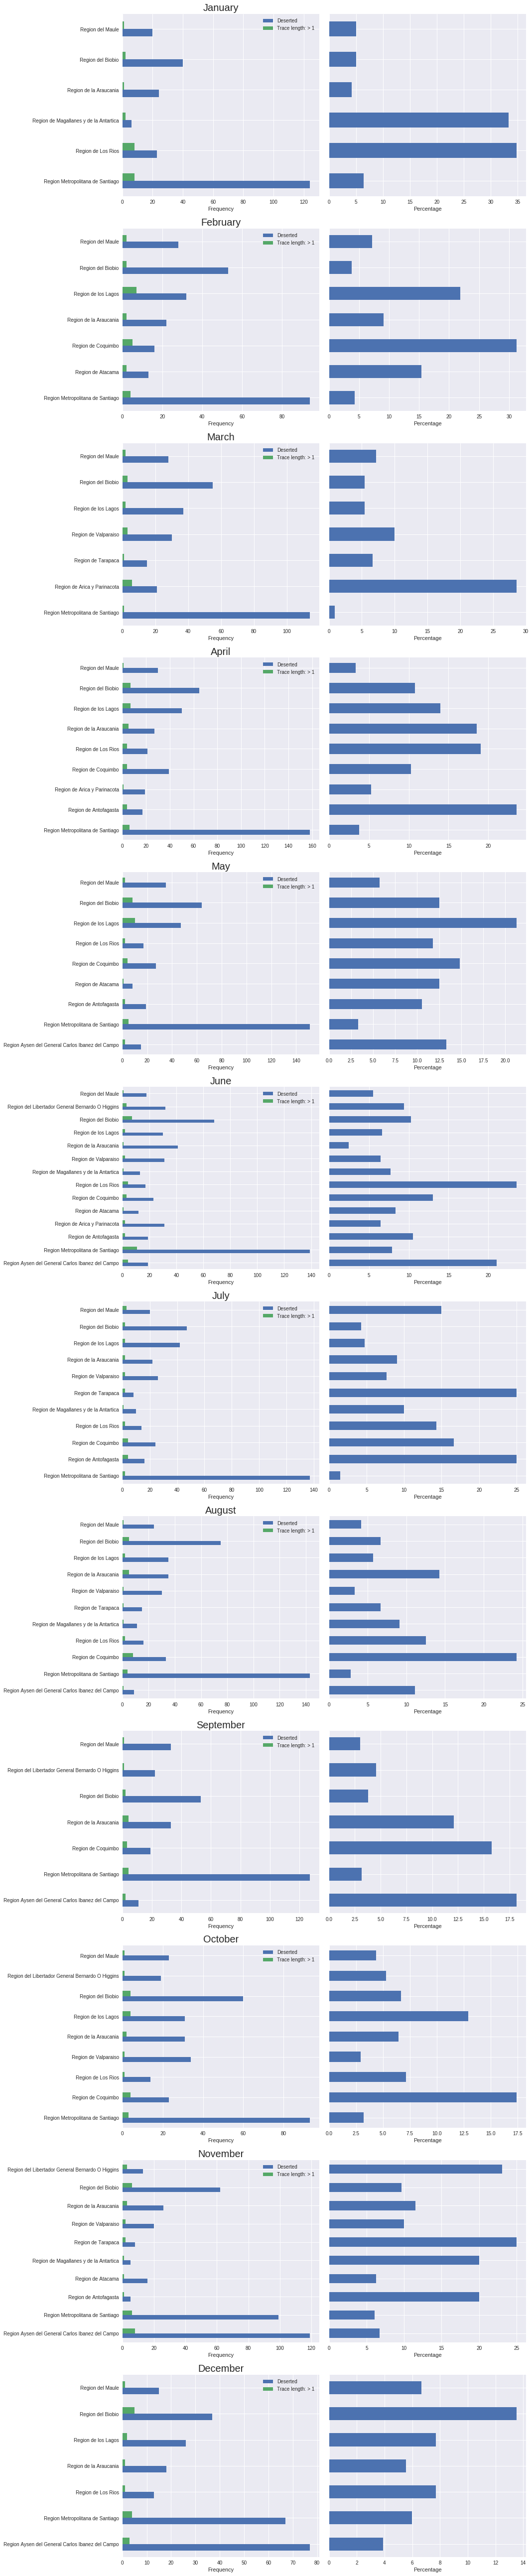

In [74]:
import calendar

def plot_trace_dist(tender_df, deserted, trace_row_df, rowid, axes):
    grouped_before = tender_df[(tender_df['CodigoExterno'].isin(deserted['CodigoExterno'].values))].groupby('CompradorRegionUnidad').size()
    grouped_after = tender_df[(tender_df['CodigoExterno'].isin(trace_row_df['CodigoExterno']))&
                             (tender_df['Estado'].str.lower().str.startswith('desi'))].groupby('CompradorRegionUnidad').size()
    
    print('{}/{} has trace length > 1'.format(grouped_after.sum(), grouped_before.sum()))
    
    grouped_before = grouped_before.to_frame().reset_index()
    grouped_after = grouped_after.to_frame().reset_index()
    grouped = grouped_before.merge(grouped_after, on='CompradorRegionUnidad')
    grouped.columns = ['CompradorRegionUnidad', 'Deserted', 'Trace length: > 1']
    grouped['perc'] = grouped['Trace length: > 1'] / grouped['Deserted'] * 100
    grouped.sort_values('CompradorRegionUnidad', inplace=True, ascending=True)

    grouped[['CompradorRegionUnidad', 'Deserted', 'Trace length: > 1']].plot(kind='barh', ax=axes[rowid, 0]);
    axes[rowid, 0].set_yticklabels(grouped['CompradorRegionUnidad'])
    axes[rowid, 0].set_xlabel('Frequency')
    axes[rowid, 0].set_title('{}'.format(calendar.month_name[rowid+1]), fontsize=20);

    grouped[['CompradorRegionUnidad', 'perc']].plot(kind='barh', ax=axes[rowid, 1], legend=None);
    axes[rowid, 1].set_yticklabels([]);
    axes[rowid, 1].set_xlabel('Percentage');

rowid_list = range(12)
fig, axes = plt.subplots(figsize=(15, 6 * 12), ncols=2, nrows=12)
for tender_df, deserted, trace_row_df, rowid in zip(tender_df_list, deserted_small_df_list, 
                                                    trace_row_df_list, rowid_list):
    plot_trace_dist(tender_df, deserted, trace_row_df, rowid, axes)

plt.tight_layout();

In [75]:
avg_revival_rate = list()
month = 1
for trace_row_df in trace_row_df_list:
    grouped_state = trace_row_df.groupby('Nombre').apply(lambda x: 'Adjudicada' in x['Estado'].values)
    revival_rate = (grouped_state.sum() / grouped_state.shape[0])
    print('Revival rate ({:02d}): {:.2f}% ({}/{})'.format(month, revival_rate, grouped_state.sum(), grouped_state.shape[0]))
    month += 1
    avg_revival_rate.append((revival_rate, grouped_state.shape[0]))

total_sale = fcts.reduce(lambda x, y: x + y[1], avg_revival_rate, 0)
avg_revival_rate = fcts.reduce(lambda x, y: x + y[0] * (y[1] / total_sale), avg_revival_rate, 0)
print('Weighted avg revival rate: {:.2f}'.format(avg_revival_rate))

Revival rate (01): 0.60% (9/15)
Revival rate (02): 0.74% (14/19)
Revival rate (03): 0.88% (14/16)
Revival rate (04): 0.77% (24/31)
Revival rate (05): 0.58% (15/26)
Revival rate (06): 0.60% (18/30)
Revival rate (07): 0.76% (16/21)
Revival rate (08): 0.75% (18/24)
Revival rate (09): 0.71% (10/14)
Revival rate (10): 0.60% (9/15)
Revival rate (11): 0.55% (12/22)
Revival rate (12): 0.79% (11/14)
Weighted avg revival rate: 0.69


En general, las trazas de licitaciones que tienen un largo mas que 2 tienen una probabilidad de ~70% a volverse a ser adjudicado.

### Distribution in terms of product category

In [76]:
grouped_cat = tprod_df[
    (tprod_df['CodigoExterno'].isin(trace_row_df['CodigoExterno'].values))
].groupby('Categoria').size().to_frame().reset_index()

grouped_cat.columns = ['Categoria', 'count']
grouped_cat.sort_values('count', inplace=True, ascending=False)
grouped_cat.reset_index(drop=True, inplace=True)

grouped_cat.head()

,Categoria,count
0,Instrumentos musicales juegos juguetes artesanias y materiales educativos / Juguetes y juegos / Juguetes,36
1,Articulos de fabricacion y produccion / Articulos de ferreteria / Tornillos,20
2,Servicios de transporte almacenaje y correo / Transporte de pasajeros / Transporte de pasajeros por carretera,14
3,Equipos y suministros de defensa orden publico proteccion y seguridad / Proteccion contra incendios / Equipos para combatir incendios,12
4,Articulos de fabricacion y produccion / Articulos de ferreteria / Espaciadores,12


## Divide to two classes

In [77]:
def merge_df(trace_row_df):
    grouped_state = trace_row_df.groupby('Nombre').apply(lambda x: int('Adjudicada' in x['Estado'].values))
    grouped_state = grouped_state.to_frame().reset_index()
    grouped_state.columns = ['Nombre', 'class_sold']

    merged = trace_row_df.merge(grouped_state, on='Nombre')
    merged[(merged['class_sold']==0)]

    return merged

merged_df_list = list()
for trace_row_df in trace_row_df_list:
    merged = merge_df(trace_row_df)
    merged_df_list.append(merged)

### Revived case
An example where a tender gets revived in a re-publication.

In [78]:
merged_all_df = pd.concat(merged_df_list, axis=0)

merged_all_df[
    (merged_all_df['CodigoExterno'].isin(['2401-442-L116', '2401-467-L116']))
]

,Estado,FechasFechaPublicacion,FechasFechaCierre,Nombre,CompradorNombreOrganismo,CompradorCodigoOrganismo,AdjudicacionUrlActa,CodigoExterno,class_sold
4,Desierta o art 3 o 9 Ley 19 886,2016-11-02 15:33:25.950,2016-11-08T12:01:00,MOCHILAS PROYECTO INFANCIA,ILUSTRE MUNICIPALIDAD DE RANCAGUA,87167,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=t27FwHY6GxhIEjFmTlRD6yyYduI7UlEBWC6N4Q0ABXo=,2401-442-L116,1
5,Adjudicada,2016-11-15 17:04:11.183,2016-11-22T12:00:00,MOCHILAS PROYECTO INFANCIA,ILUSTRE MUNICIPALIDAD DE RANCAGUA,87167,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=ckCgGyh5kukvjtTq6rUOy23XxwBsgCyz3x7T4cedS3k=,2401-467-L116,1


### Remains dead
An example where a tender remains deserted in the future re-publication.

In [79]:
merged_all_df[
    (merged_all_df['CodigoExterno'].isin(['1989-99-L116', '1989-104-CO16']))
]

,Estado,FechasFechaPublicacion,FechasFechaCierre,Nombre,CompradorNombreOrganismo,CompradorCodigoOrganismo,AdjudicacionUrlActa,CodigoExterno,class_sold
2,Desierta o art 3 o 9 Ley 19 886,2016-11-02 15:23:50.373,2016-11-10T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=HJfcGaPNPX9fLUtNwNIuJVnzatvdmhHFwZl9efRvz+U=,1989-99-L116,0
3,Desierta o art 3 o 9 Ley 19 886,2016-11-23 16:37:08.103,2016-12-01T09:00:00,Examen Ocupacional a Personal del Aeropuerto Diego Aracena,Direccion General de Aeronautica Civil,7202,http://www.mercadopublico.cl/Procurement/Modules/RFB/StepsProcessAward/PreviewAwardAct.aspx?qs=Qn8nkbm19kyaC/lMqhdo9XBRJBMJ0G6q2k62Rth9e/I=,1989-104-CO16,0


## Constructing trace df with features

In [80]:
def compute_lapse(tname, df):
    trace = df[(df['Nombre']==tname)]
    last = None
    lapse_list = list()
    for tender in trace.itertuples():
        now = tender
        if last is not None:
            # compute lapse
            lapse_list.append(now.FechasFechaPublicacion - last.FechasFechaCierre)
        last = now
    return np.mean(lapse_list)

def compute_duration(tname, df):
    return df.loc[(df['Nombre']==tname), 'tender_duration'].mean()

def cmp_desc_chg(tname, df):
    trace = df[(df['Nombre']==tname)]
    last = None
    change_list = list()
    for tender in trace.itertuples():
        now = tender
        if last is not None:
            # compute lapse
            change_list.append(now.desc_len - last.desc_len)
        last = now
    return np.mean(change_list)

def cmp_trace_len(tname, df):
    return df[(df['Nombre']==tname)].shape[0]

In [81]:
tall_df_list = list()

for tender_df, tprod_df in zip(tender_df_list, tprod_df_list):
    tall_df = tprod_df.merge(tender_df, on='CodigoExterno')
    tall_df_list.append(tall_df)

In [82]:
def compute_tender_duration(df):
    df['FechasFechaPublicacion'] = pd.to_datetime(df.loc[:,'FechasFechaPublicacion'])
    df['FechasFechaCierre'] = pd.to_datetime(df.loc[:,'FechasFechaCierre'])
    df['tender_duration'] = df['FechasFechaCierre'] - df['FechasFechaPublicacion']

In [83]:
def get_avg_df(tall_df):
    # product code, region, average number of words in description, item quantity, reclamos, 
    aux = tall_df[['CodigoProducto', 'CompradorRegionUnidad', 'Descripcion_x', 
                   'ItemsCantidad', 'CantidadReclamos', 'CodigoExterno']]
    aux['desc_len'] = aux['Descripcion_x'].astype(str).apply(lambda x: len(x))
    aux['desc_len'] = aux['desc_len'].fillna(0)
#    print(aux['desc_len'].unique())
    frame = aux.groupby('CodigoExterno').agg({'desc_len': 'mean'})
    frame = frame.reset_index()
    aux = aux.drop('desc_len', axis=1)
    aux = aux.merge(frame, on='CodigoExterno')
    aux.drop_duplicates('CodigoExterno', inplace=True)
    return aux

tall_avg_df_list = list()
for tall_df in tall_df_list:
    tall_avg_df = get_avg_df(tall_df)
    tall_avg_df_list.append(tall_avg_df)

In [84]:
def get_trace_df(merged, tall_avg_df):
    trace_df = merged[['Nombre', 'class_sold', 'CompradorCodigoOrganismo', 'CodigoExterno',
                      'FechasFechaPublicacion', 'FechasFechaCierre']]
    compute_tender_duration(trace_df)
    trace_df.loc[:,'lapse'] = trace_df.loc[:,'Nombre'].apply(lambda x: compute_lapse(x, trace_df))
    trace_df['avg_tduration'] = trace_df.loc[:,'Nombre'].apply(lambda x: compute_duration(x, trace_df))
    
    # trace_df = trace_df.merge(merged[['Nombre', 'CodigoExterno']], on='Nombre')
    trace_df = trace_df.merge(tall_avg_df, on='CodigoExterno')
    trace_df['name_len'] = trace_df['Nombre'].apply(len) 
    trace_df['avg_desc_chg'] = trace_df['Nombre'].apply(lambda x: cmp_desc_chg(x, trace_df))
    trace_df['trace_len'] = trace_df['Nombre'].apply(lambda x: cmp_trace_len(x, trace_df))
    trace_df = trace_df[[colname for colname in trace_df.columns if colname != 'CodigoExterno']]
    trace_df = trace_df[[colname for colname in trace_df.columns 
                         if not (colname == 'Descripcion_x' or colname == 'CodigoExterno' 
                                 or colname == 'Nombre' or colname == 'FechasFechaPublicacion' 
                                or colname == 'FechasFechaCierre' or colname == 'tender_duration' 
                                or colname == 'CodigoProducto') ]]
    # convert timedelta columns to hours
    trace_df['lapse'] = trace_df['lapse'].dt.components.hours
    trace_df['avg_tduration'] = trace_df['avg_tduration'].dt.components.hours
    
    return trace_df

trace_df_list = list()
for merged_df, tall_avg_df in zip(merged_df_list, tall_avg_df_list):
    trace_df = get_trace_df(merged_df, tall_avg_df)
    trace_df_list.append(trace_df)

In [85]:
trace_df = pd.concat(trace_df_list, axis=0)

### Convert to numerical

In [86]:
from sklearn import preprocessing

# make the following columns to string so that they can be mapped to lower values for training
trace_df['CompradorCodigoOrganismo'] = trace_df['CompradorCodigoOrganismo'].astype(str)
# trace_df['CodigoProducto'] = trace_df['CodigoProducto'].astype(str)

le_dict = dict()
for col in trace_df.columns:
    if np.issubdtype(trace_df[col].dtype, np.number):
        continue
    le = preprocessing.LabelEncoder()
    # fit the labels
    _ = le.fit(trace_df[col])
    # transform the labels
    trace_df[col] = le.transform(trace_df[col])
    # save the labeler
    le_dict[col] = le

### Quitar columnas con baja varianza

In [87]:
var_threshold = .01
for col in trace_df.columns:
    if trace_df[col].var() < var_threshold:
        print('Removing column: {}'.format(col))
        trace_df.drop(col, axis=1, inplace=True)

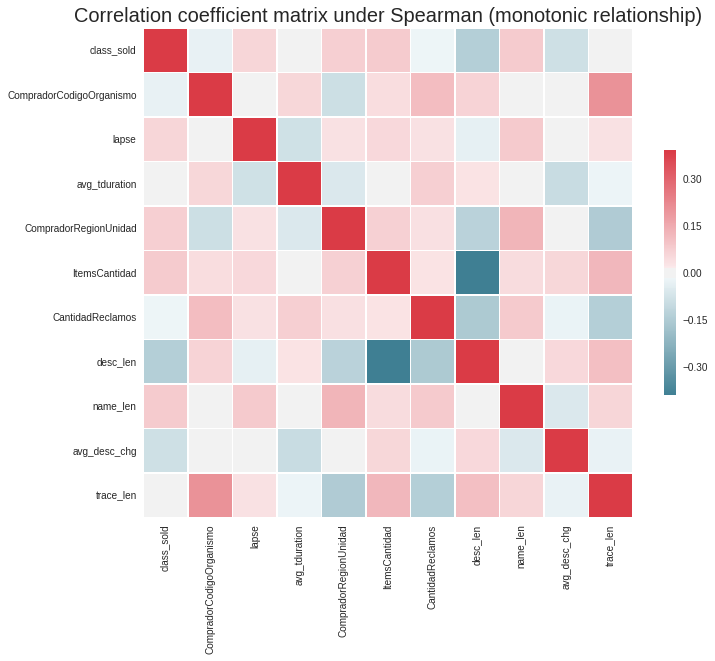

In [88]:
import seaborn as sns

corr = trace_df.corr('spearman')

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
               square=True, linewidth=.5, cbar_kws={'shrink': .5})

_ = ax.set_title('Correlation coefficient matrix under Spearman (monotonic relationship)', fontsize=20)

Podemos ver que el largo de las descripciones tiene una relacion con el estado final de las trazas (vamos a identificar esto luego en los resultados de clasificacion.) Y la cantidad de items tiene una relacion negativa con el largo de las descripcion; eso tiene sentido dado la observacion anterior que la gente suele incluir menos detallas con licitaciones de muchos productos.

## Clasificacion con class_sold

In [89]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn.dummy import DummyClassifier

'''
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
'''
names = ["Dummy (Stratified)", "Nearest Neighbors", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    DummyClassifier(strategy='stratified', random_state=0, constant=0),
    KNeighborsClassifier(3),
#    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

'\nnames = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",\n         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",\n         "Naive Bayes", "QDA"]\n'

### Distribucion de la clase objetivo

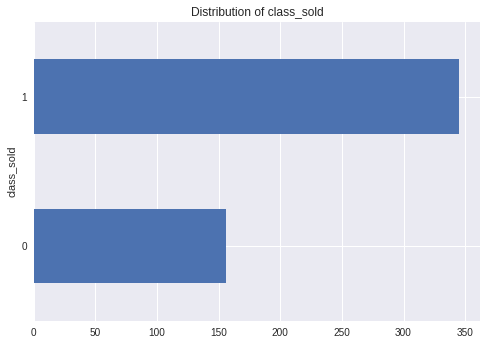

In [90]:
grouped = trace_df.groupby('class_sold').size()
ax = grouped.plot(kind='barh')
ax.set_title('Distribution of class_sold');

### Crear train y test sets

In [91]:
dataset_y = trace_df['class_sold']
dataset_X = trace_df.drop('class_sold', axis=1)

train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y, test_size=.4, random_state=123)

# there can be overlap between train and test sets where there are instances duplicated in both train and test
# for fairer test, remove those from test
train = pd.concat([train_X, train_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)
before = test.shape[0]

merged = pd.merge(test, train, how='outer', indicator=True)
# select only left_only, i.e., unique test set instances
test_no_dup = merged.loc[merged._merge=='left_only']
test_no_dup.drop('_merge', inplace=True, axis=1)
after = test_no_dup.shape[0]
print('Removed {} rows from test set with original: {}'.format(before - after, before))
print('Removed {:.2f}% of original'.format((before - after) / before * 100))

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# oversample train set
grouped = train.groupby('class_sold').size()
to_oversample = int(abs(grouped.diff()[1]))
print('Oversampling {} rows...'.format(to_oversample))
idx = np.random.choice(train.loc[train['class_sold'] == 0].index, size=to_oversample)
train_oversampled = pd.concat([train, train.iloc[idx]])

train_ds_list = [train, train_oversampled]
train_ds_namelist = ['Original', 'Oversampled']

test_ds_list = [test, test_no_dup]
test_ds_namelist = ['Original', 'No duplicates']

Removed 92 rows from test set with original: 201
Removed 45.77% of original
Oversampling 98 rows...


In [92]:
import multiprocessing
from multiprocessing import Queue
import math

In [93]:
# parallelize at the level of classifiers
def mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs):
    def worker(train_X, train_y, test_X, test_y, name_list, clf_list, out_q):
        '''
        The worker function, invoked in a process. 
        '''
        outdict = {}
        for name, clf in zip(name_list, clf_list):
            # train and test classifier
            # print('Training {}...'.format(name))
            clf.fit(train_X, train_y)
            # print('Testing {}...'.format(name))
            y_pred = clf.predict(test_X)
#            report = classification_report(y_pred=y_pred, y_true=test_y)
            scores = precision_recall_fscore_support(y_pred=y_pred, y_true=test_y)
            score_list = list(zip([name for _ in range(len(scores[0]))], clf.classes_,
                                 scores[0], scores[1], scores[2], scores[3]))
            # put report to dict
            outdict[name] = score_list
        # put to out_q
        out_q.put(outdict)
        
    # Each process wil get 'chunksize' clfs and a queue to put the outdict in
    out_q = Queue()
    chunksz = int(math.ceil(len(classifiers) / float(nprocs)))
    procs = []
    
    for i in range(nprocs):
        start = chunksz * i
        end = chunksz * (i + 1)
        p = multiprocessing.Process(
                target=worker,
                args=(train_X, train_y, test_X, test_y, 
                      names[start:end], classifiers[start:end], out_q))
        procs.append(p)
        p.start()
    
    # Collect all results into a single result dict
    resultdict = dict()
    for i in range(nprocs):
        outdict = out_q.get()
        resultdict.update(outdict)
    # turn resultdict to dataframe
    # print(list(resultdict.values()))
    values = fcts.reduce(lambda l, x: l + x, list(resultdict.values()))
    values = list(zip(*values))
    value_dict = {'clf': values[0], 'class': values[1],
                'precision': values[2], 'recall': values[3],
                'f1': values[4], 'support': values[5]}
    result_df = pd.DataFrame(value_dict)
        
    # wait for all worker processes to finish
    for p in procs: 
        p.join()
    
    return result_df

In [94]:
nprocs = multiprocessing.cpu_count()
# print(nprocs)

result_df = pd.DataFrame()
for train_ds_name, train_ds in zip(train_ds_namelist, train_ds_list):
    train_X = train_ds.drop('class_sold', axis=1)
    train_y = train_ds['class_sold']
    # print('Training on {} dataset'.format(train_ds_name))
    
    for test_ds_name, test_ds in zip(test_ds_namelist, test_ds_list):
        test_X = test_ds.drop('class_sold', axis=1)
        test_y = test_ds['class_sold']
        # los experimentos fueron realizados en otro computador, solamente importamos los resultados
        
        out_df = mp_classify(train_X, train_y, test_X, test_y, names, classifiers, nprocs)
        # columns about train and test set
        out_df['train'] = [train_ds_name for _ in range(out_df.shape[0])]
        out_df['test'] = [test_ds_name for _ in range(out_df.shape[0])]
        out_df = out_df[['train', 'test', 'clf', 'class', 'precision', 'recall', 'f1', 'support']]
        if result_df.empty:
            result_df = out_df
        else:
            result_df = pd.concat([result_df, out_df], axis=0)

'''
outdir = '.' + os.sep + 'out'
if not os.path.isdir(outdir):
    os.makedirs(outdir)
result_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)
'''

# result_df = pd.read_csv('.' + os.sep + 'out' + os.sep + 'classificationResult.csv');

"\noutdir = '.' + os.sep + 'out'\nif not os.path.isdir(outdir):\n    os.makedirs(outdir)\nresult_df.to_csv(outdir + os.sep + 'classificationResult.csv', index=None)\n"

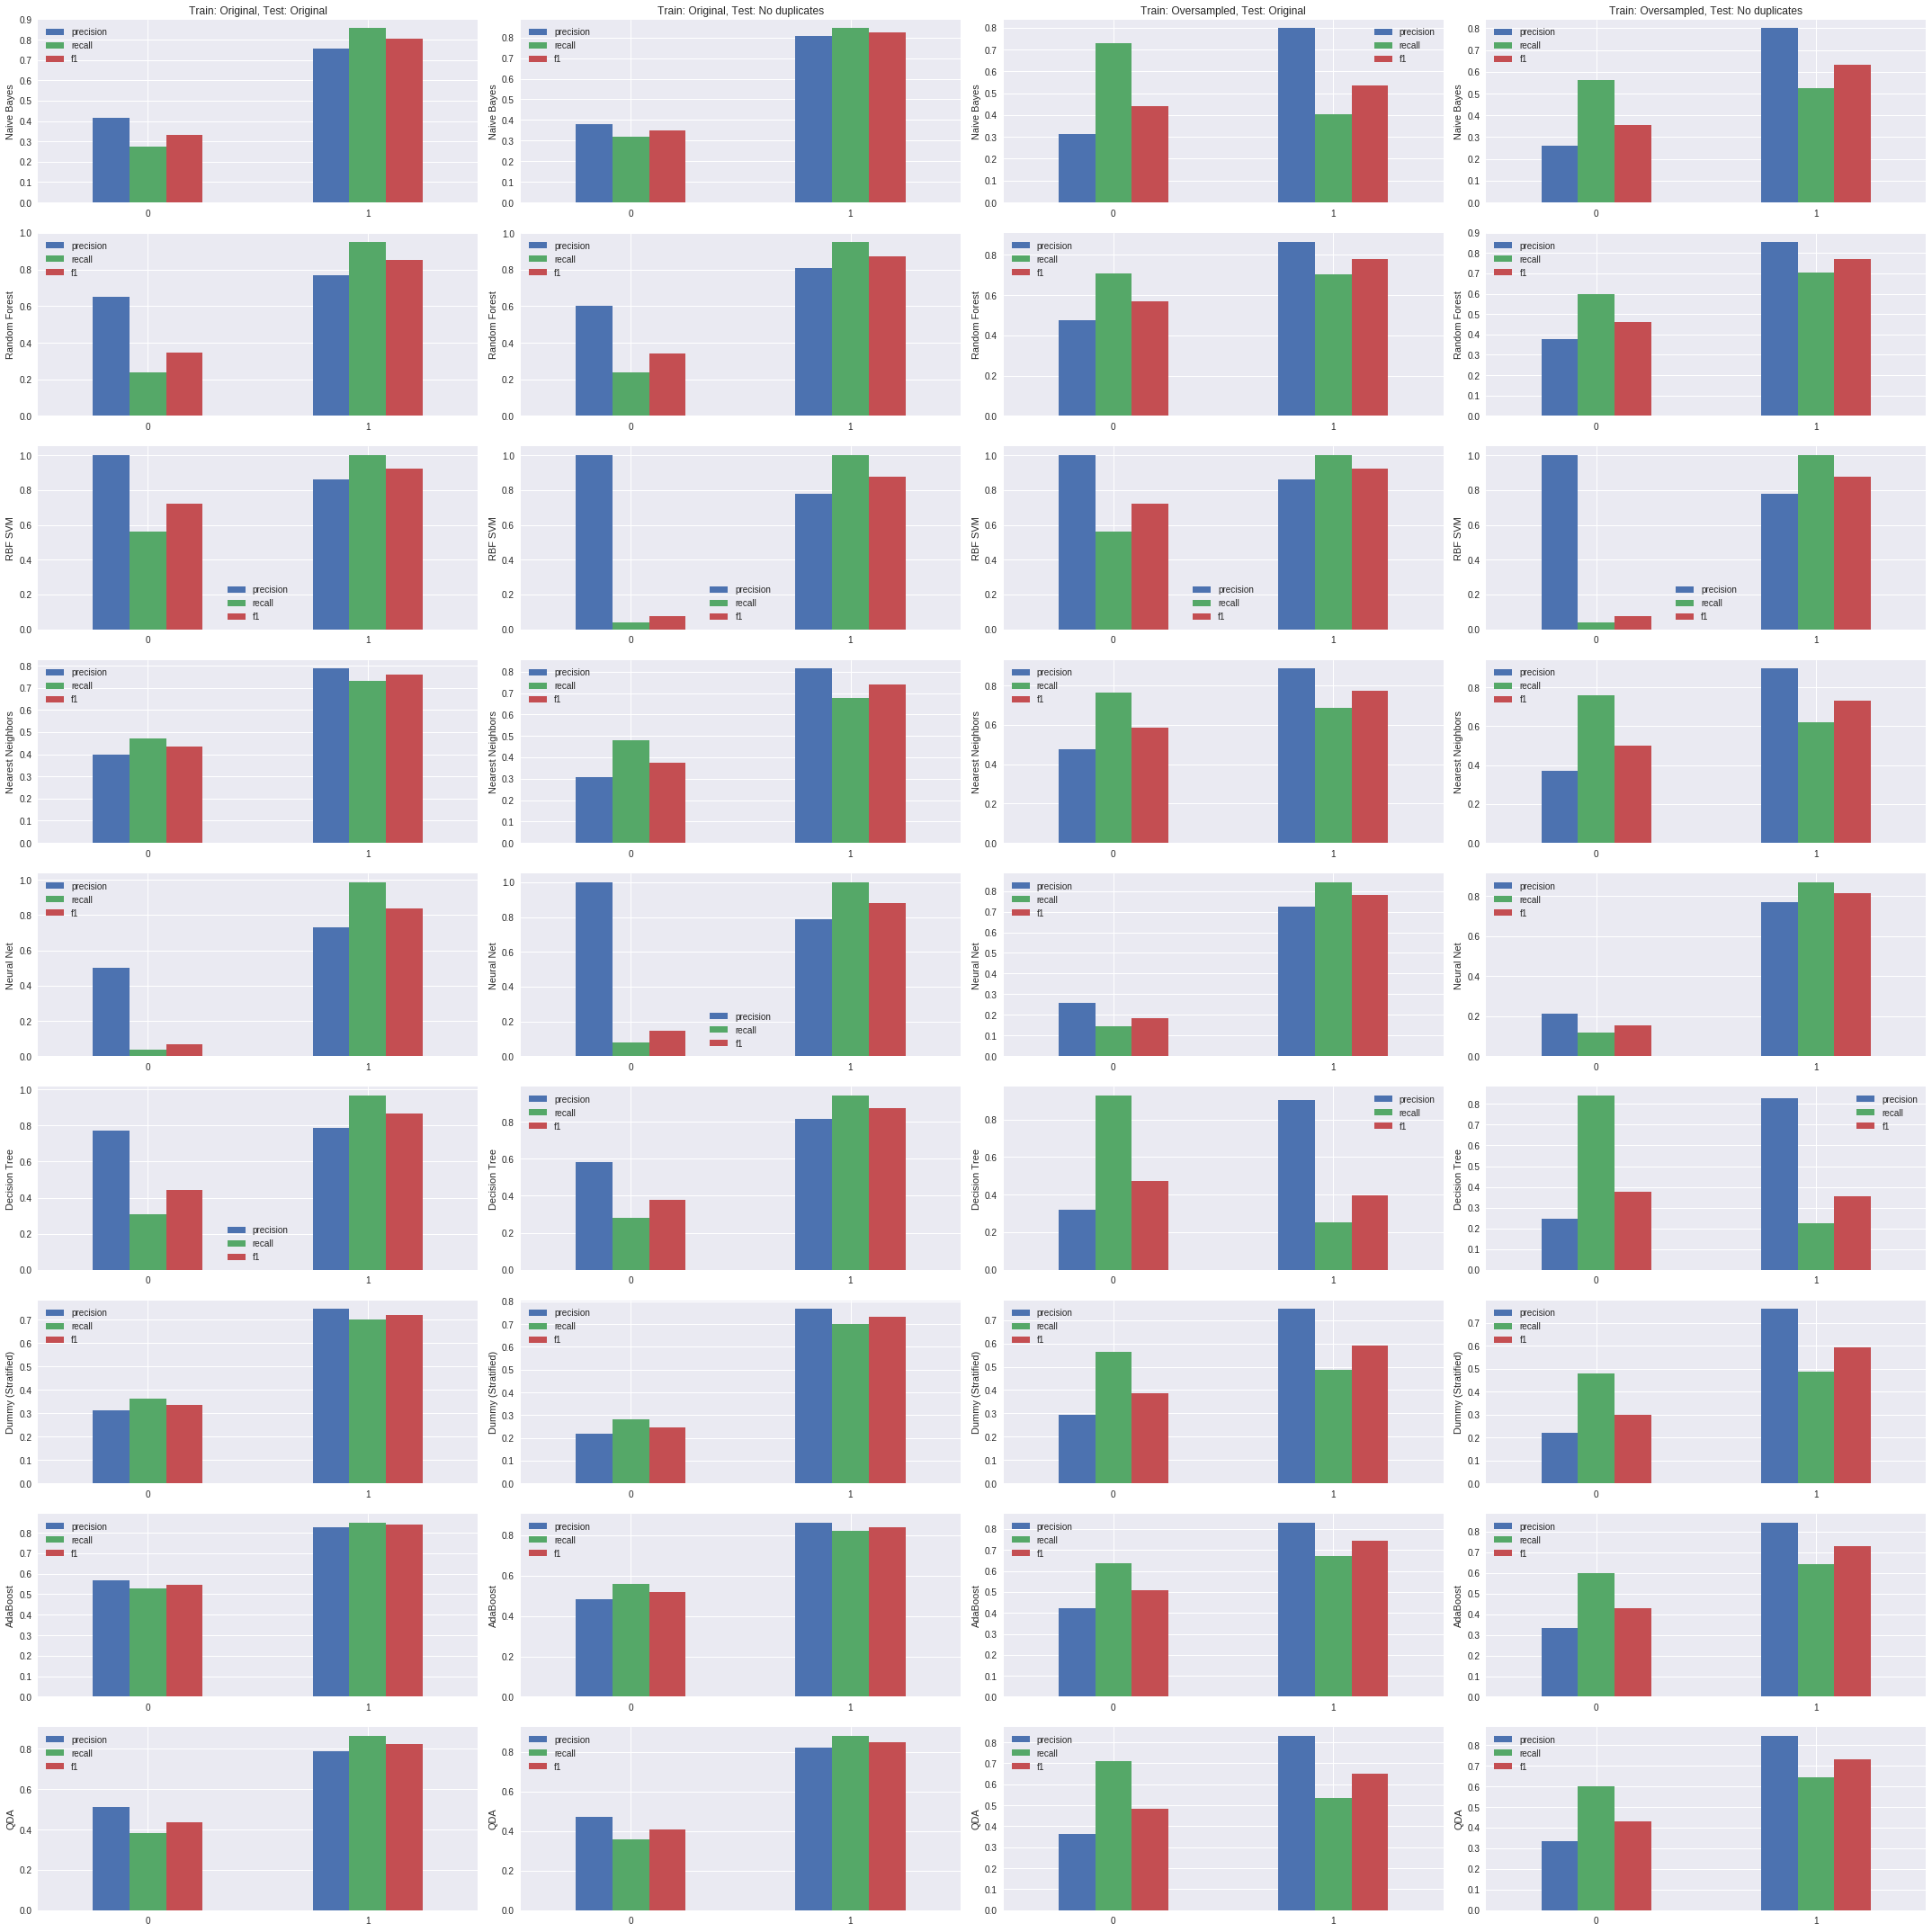

In [95]:
nrows = result_df.clf.unique().shape[0]
ncols = result_df[['train', 'test']].drop_duplicates().shape[0]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))

clfs = result_df.clf.unique()
train_test_pairs = result_df[['train', 'test']].drop_duplicates().values

for i in range(nrows):
    clf = clfs[i]
    clf_results = result_df[(result_df.clf == clf)]
    for j in range(ncols):
        train_test_pair = train_test_pairs[j]
        # print(train_test_pair)
        ax = axes[i, j]
        result = clf_results[(clf_results['train']==train_test_pair[0])&
                            (clf_results['test']==train_test_pair[1])]
        # print(result)
        _ = result[['precision', 'recall', 'f1']].plot(kind='bar', ax=ax, rot=0);
        
        if i == 0:
            _ = ax.set_title('Train: {}, Test: {}'.format(train_test_pair[0], train_test_pair[1]))
        _ = ax.set_ylabel('{}'.format(clf))
        _ = ax.set_xticklabels(result['class'])
        
# plt.savefig('./classificationResult.png')
plt.tight_layout()

In [96]:
# test with original train and no duplicates for test
train_ds = train_ds_list[0]
test_ds = test_ds_list[1]

train_X = train_ds.drop('class_sold', axis=1)
train_y = train_ds['class_sold']

test_X = test_ds.drop('class_sold', axis=1)
test_y = test_ds['class_sold']

for name, clf in zip(names, classifiers):
    if name not in ["Dummy (Stratified)", "Nearest Neighbors", 
         "Decision Tree", "Random Forest", "AdaBoost"]:
        continue
    _ = clf.fit(train_X, train_y);
    y_pred = clf.predict(test_X);
    report = classification_report(y_pred=y_pred, y_true=test_y);
    print('{}'.format(name))
    print(report);
    print();

Dummy (Stratified)
             precision    recall  f1-score   support

          0       0.22      0.28      0.25        25
          1       0.77      0.70      0.73        84

avg / total       0.64      0.61      0.62       109


Nearest Neighbors
             precision    recall  f1-score   support

          0       0.31      0.48      0.38        25
          1       0.81      0.68      0.74        84

avg / total       0.70      0.63      0.66       109


Decision Tree
             precision    recall  f1-score   support

          0       0.58      0.28      0.38        25
          1       0.81      0.94      0.87        84

avg / total       0.76      0.79      0.76       109


Random Forest
             precision    recall  f1-score   support

          0       0.50      0.24      0.32        25
          1       0.80      0.93      0.86        84

avg / total       0.73      0.77      0.74       109


AdaBoost
             precision    recall  f1-score   support

        

In [97]:
# get the original, no duplicates pair
train_ds = train_ds_list[0]
test_ds = test_ds_list[1]

train_X = train_ds.drop('class_sold', axis=1)
train_y = train_ds['class_sold']

test_X = test_ds.drop('class_sold', axis=1)
test_y = test_ds['class_sold']

ds_X = pd.concat([train_X, test_X], axis=0)
ds_y = pd.concat([train_y, test_y], axis=0)

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(ds_X, ds_y)

In [98]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(clf, out_file='tree.dot',
                               feature_names=train_X.columns,
                               class_names=['Deserted', 'Sold'],
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)


### Analisis del arbol de decision
![tree](./out/tree.png)

Se puede ver que los features funcionan pero tenemos un poco overfitting sobre algunos de los ejemplos.

## E2: Clustering
En este segundo experimento vamos a usar clustering para ver si existe algun cluster con los features de las trazas.

In [99]:
from sklearn import metrics
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import kneighbors_graph
import warnings, time
from itertools import cycle, islice


### Escalar valores a [0, 1]

In [100]:
# remove the class_sold
cluster_ds = trace_df.drop('class_sold', axis=1)
min_max_scaler = MinMaxScaler()
cluster_ds_scaled = min_max_scaler.fit_transform(cluster_ds)
# cluster_ds_scaled = StandardScaler().fit_transform(cluster_ds)
cluster_ds_scaled = pd.DataFrame(cluster_ds_scaled)
cluster_ds_scaled.columns = cluster_ds.columns

### Prueba de codo para encontrar numero de cluster

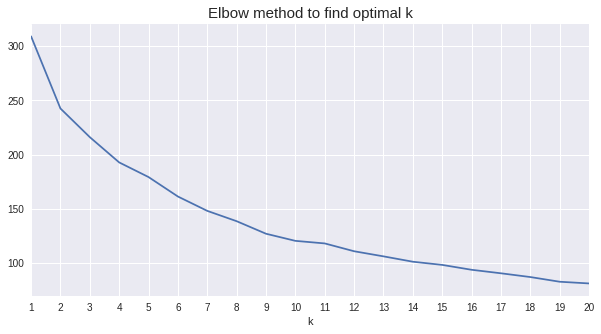

In [101]:
# test until 20 k
maxK = 20
sse_list = np.zeros(maxK)
# number of different initial centroids
n_init = 20
n_jobs = -1
for i in range(maxK):
    k = i + 1
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=k, n_jobs=n_jobs).fit(cluster_ds_scaled)
    # get the sse from kmeans
    sse_list[i] = kmeans.inertia_
    
sse_zip = list(zip(*enumerate(sse_list)))
sse_dict = {'k': sse_zip[0],
           'sse': sse_zip[1]}
sse_df = pd.DataFrame(sse_dict)
sse_df.k = sse_df.k.apply(lambda x: x + 1)

sse_df.set_index(sse_df.k, inplace=True)
ax = sse_df.sse.plot(xticks=sse_df.index, figsize=(10, 5))
_ = ax.set_title('Elbow method to find optimal k', fontsize=15)

In [102]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Explained variance ratio (first two components): [ 0.2425216  0.1961849]


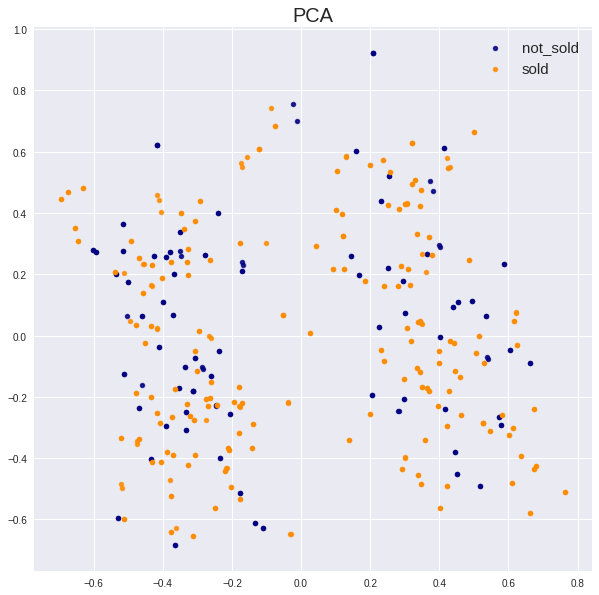

In [103]:
y = trace_df['class_sold']
target_names = ['not_sold', 'sold']
pca = PCA(n_components=2)
X_r = pca.fit(cluster_ds_scaled).transform(cluster_ds_scaled)

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): {}'.format(str(pca.explained_variance_ratio_)))

fig, ax = plt.subplots(figsize=(10, 10))
colors = ['navy', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_r[y==i, 0], X_r[y==i, 1], color=color, alpha=.8, lw=lw,
               label=target_name, s=12)
ax.legend(loc='best', shadow=False, scatterpoints=1, fontsize=15)
ax.set_title('PCA', fontsize=20);

fig.savefig('./out/pca.png');

Podemos ver a ojo que hay al menos 2 clusters, pero la clase sold no tiene mucho sentido en la visualizacion de PCA.

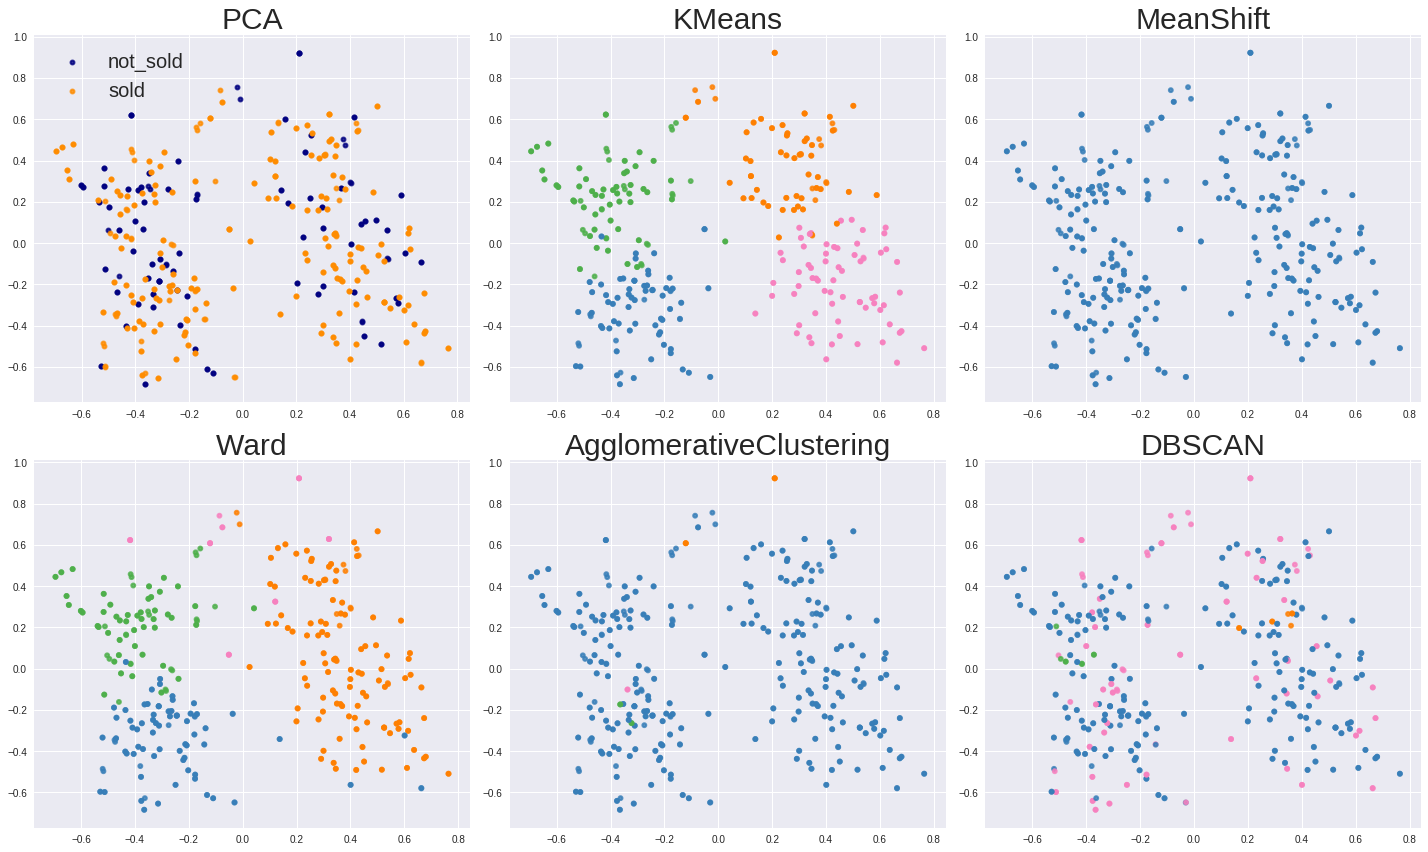

In [104]:
params = {'quantile': .6,
               'eps': .4,
               'damping': .9,
               'preference': -200,
               'n_neighbors': 10, 
               'n_clusters': 4}

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(cluster_ds_scaled.values, quantile=params['quantile'])

# connectivity matrix for structured ward
connectivity = kneighbors_graph(cluster_ds_scaled, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# create the cluster objects
kmeans = cluster.KMeans(n_clusters=params['n_clusters'], n_jobs=-1)
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity
)
dbscan = cluster.DBSCAN(eps=params['eps'])
average_linkage = cluster.AgglomerativeClustering(
    linkage='average', affinity='cityblock', 
    n_clusters=params['n_clusters'], connectivity=connectivity)

clustering_algorithms = (
    ('KMeans', kmeans),
#    ('MiniBatchMeans', two_means),
    ('MeanShift', ms),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan)
)

s = 15
cnt = 1
nrows = 2
ncols = 3
fig, axes = plt.subplots(figsize=(20, 12), nrows=nrows, ncols=ncols)
true_y = trace_df['class_sold']
target_names = ['not_sold', 'sold']
pca = PCA(n_components=2)
X_r = pca.fit(cluster_ds_scaled).transform(cluster_ds_scaled)

colors = ['navy', 'darkorange']
lw = 2
for color, i, target_name in zip(colors, [0, 1], target_names):
    axes[0, 0].scatter(X_r[y==i, 0], X_r[y==i, 1], color=color, alpha=.8, lw=lw,
               label=target_name, s=s)
axes[0, 0].legend(loc='best', shadow=False, scatterpoints=1, fontsize=20)
axes[0, 0].set_title('PCA', fontsize=30);

for name, algorithm in clustering_algorithms:
    t0 = time.time()
    
    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(cluster_ds_scaled)
    
    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(cluster_ds_scaled)
    
    row = cnt // ncols
    col = cnt % ncols
    cnt += 1
    
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
    axes[row, col].scatter(X_r[:, 0], X_r[:, 1], color=colors[y_pred], alpha=.8, lw=lw, s=s)
    axes[row, col].set_title('{}'.format(name), fontsize=30);

plt.tight_layout();

Podemos ver que KMeans podia identificar los cuatro clusters. Y quizas DBSCAN tiene algo dado que esta buscando cluster de densidad, los cluster identificados quizas tienen sentido en las 10 dimensiones.

# E3: Competitividad de proveedores

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from functools import reduce

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC  # support vector machine classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
%matplotlib inline

In [106]:
df = pd.read_csv('./data/dataNov2016/tender.csv', sep=',')
df_product = pd.read_csv('./data/dataNov2016/tenderProduct.csv', sep=',')

df_total = df.merge(df_product, on='CodigoExterno')

# df_total.columns

## 100 productos mas populares:

In [107]:
provider_df = df_total[['AdjudicacionNombreProveedor','CodigoProducto']]
top_100 = list(provider_df.CodigoProducto.value_counts().index)[0:100]

In [108]:
### dejamos solo proveedores de productos top 100 mas ofrecidos:
provider_df = provider_df[provider_df['CodigoProducto'].isin(top_100)]

In [109]:
lista_proveedores = list(provider_df.AdjudicacionNombreProveedor)

In [110]:
# productos del provvedor 1 (humanitas aysen)
provider_1 = list(provider_df.loc[provider_df['AdjudicacionNombreProveedor'] == lista_proveedores[1]]['CodigoProducto'])

In [111]:
# diccionario codigo producto con cantidad de veces que aparece 
keys = provider_df.CodigoProducto.value_counts().index
values = provider_df.CodigoProducto.value_counts().values
diccionario = dict(zip(keys, values))
# diccionario

In [112]:
# diccionario con codigo proveedor y lista productos 

diccionario_proveedores = {}

for x in lista_proveedores:
    diccionario_proveedores[x] = list((provider_df.loc[provider_df['AdjudicacionNombreProveedor'] == x]['CodigoProducto']))

In [113]:
lista_resultado = []

for x in diccionario_proveedores:
    suma = 0
    
    if str(x) == 'nan':
        continue
    
    for y in list(set(diccionario_proveedores[x])):
        suma+= diccionario[y]

    lista_resultado.append([x,len(diccionario_proveedores[x])/suma])

# print(lista_resultado)
    
        

In [114]:
lista_resultado.sort(key=lambda x: x[1], reverse = True)

In [115]:
df_probabilidad = pd.DataFrame(lista_resultado, columns = ['proveedor', 'prob'])
df_probabilidad = df_probabilidad.drop_duplicates(subset='proveedor', keep= 'first')

In [116]:
# 0 no exitosa, 1 medianamente exitosa, 2 exitosa
def tramo_success(row):
    if 0 < row['prob'] < 0.003:
        return 0
    if 0.003 <= row['prob'] < 0.005:
        return 1    
    else:
        return 2

In [117]:
df_probabilidad['tramo'] = df_probabilidad.apply (lambda row: tramo_success(row),axis=1)
df_probabilidad.columns = ['AdjudicacionNombreProveedor', 'prob', 'tramo']

### ahora lo cruzamos con dataset para que tenga mas features, considerar promedio (mean)

In [118]:
df_clasificacion = df_probabilidad.merge(df_total, on='AdjudicacionNombreProveedor')
# dejamos columnas que nos interesan 
df_clasificacion = df_clasificacion[['AdjudicacionNombreProveedor', 'tramo','CompradorRegionUnidad', 'MontoEstimado', 'AdjudicacionCantidad', 'AdjudicacionMontoUnitario','Cantidad']]

In [119]:
# obtenemos promedio de los features
df_clasificacion = df_clasificacion.groupby(['AdjudicacionNombreProveedor', 'tramo', 'CompradorRegionUnidad'])['MontoEstimado', 'AdjudicacionCantidad', 'AdjudicacionMontoUnitario'].mean().reset_index()

In [120]:
def label_region(row):
    if row['CompradorRegionUnidad'] == 'Region Metropolitana de Santiago' :
        return 1
    else:
        return 0
    

In [121]:
df_clasificacion['region_coded'] = df_clasificacion.apply (lambda row: label_region(row),axis=1)

### clasificacion considerando como target el tramo del proveedor y features: 

In [122]:
# from mlxtend.classifier import EnsembleVoteClassifier

# probamos 4 clasificadores 
c0 = DummyClassifier(strategy='stratified')
c1 = DecisionTreeClassifier()
c2 = GaussianNB()
c3 = KNeighborsClassifier(n_neighbors=6)
c4 = RandomForestClassifier(random_state=10)
# voting_clf = EnsembleVoteClassifier(clfs=[c0, c1, c2, c3], voting='soft')

In [123]:
# data 
X = df_clasificacion[['MontoEstimado', 'region_coded','AdjudicacionCantidad',  'AdjudicacionMontoUnitario' ]]
X = X.fillna(0)
#target 
y = df_clasificacion['tramo']
Y = y.fillna(0)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
c0.fit(X_train, y_train)
print('Dummy Classifier')
print(classification_report(y_test, c0.predict(X_test)))

c1.fit(X_train, y_train)
print('\nDecision Tree Classifier')
print(classification_report(y_test, c1.predict(X_test)))

c2.fit(X_train, y_train)
print('\nGaussian Naive Bayes Classifier')
print(classification_report(y_test, c2.predict(X_test)))

c3.fit(X_train, y_train)
print('\nKNeighbors Classiffier')
print(classification_report(y_test, c3.predict(X_test)))

c4.fit(X_train, y_train)
print('\nRandom Forest')
print(classification_report(y_test, c4.predict(X_test)));

Dummy Classifier
             precision    recall  f1-score   support

          0       0.17      0.18      0.17       169
          1       0.12      0.12      0.12       144
          2       0.74      0.73      0.73       845

avg / total       0.58      0.58      0.58      1158


Decision Tree Classifier
             precision    recall  f1-score   support

          0       0.32      0.33      0.32       169
          1       0.23      0.25      0.24       144
          2       0.79      0.77      0.78       845

avg / total       0.65      0.64      0.65      1158


Gaussian Naive Bayes Classifier
             precision    recall  f1-score   support

          0       0.50      0.07      0.12       169
          1       0.40      0.01      0.03       144
          2       0.74      0.99      0.84       845

avg / total       0.66      0.73      0.64      1158


KNeighbors Classiffier
             precision    recall  f1-score   support

          0       0.36      0.25      0.29

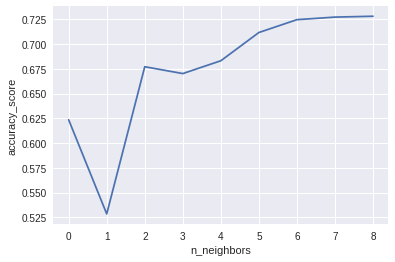

In [125]:
scores = []
for x in range(1,10):
    c3 = KNeighborsClassifier(n_neighbors=x)
    c3.fit(X_train, y_train)
    scores.append(c3.score(X_test, y_test))

plt.plot(scores)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy_score');

In [126]:
y_pred = c3.predict(X_test)
matriz = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)

In [127]:
df_confusion = pd.DataFrame(matriz, columns=('no exitosa (0)', 'mediana exitosa (1)', 'exitosa (2)'))
df_confusion.rename(index={1: 'mediana exitosa (1)', 0: ' no exitosa (0)', 2: 'exitosa (2)'})

,no exitosa (0),mediana exitosa (1),exitosa (2)
no exitosa (0),32,9,128
mediana exitosa (1),12,17,115
exitosa (2),33,18,794


## Conclusiones
En resumen, para Hito 3 hemos realizado lo siguente:
- Encontramos el fenomeno de trazas de licitaciones
- Obtuvimos la sugerencia de republicar licitaciones desiertas
- Definimos el exito de proveedores

## Direcciones futuras
- Seguir con la investigacion de trazas de licitaciones
- Otras perspectivas como la perspectiva de las organizaciones publicas
- Otras tecnicas, e.g., NLP para descripcion de las licitaciones

# Referencias

- [1] https://www.mercadopublico.cl/Home/Contenidos/QueEsMercadoPublico
- [2] https://www.mercadopublico.cl/Home/Contenidos/QueEsLicitacion
- [3] https://www.mercadopublico.cl/Home/Contenidos/QueEsCM
- [4] https://www.mercadopublico.cl/Home/Contenidos/QueEsOC
- [5] Hilbert, M. (2016). Big Data for Development: A Review of Promises and Challenges. Development Policy Review, 34(1), 135–174. http://doi.org/10.1111/dpr.12142 
- [6] J. Ben Schafer (1999), Recommender Systems in E-Commerce, University of Minnesota.
- [7] Patrick McCole (2005), A profile of adopters and non adopters of e-commerce in SMPE Professional Service Firms. 
- [8] Francisca Silva, Nicolas Majluf, Ricardo D. Paredes Pontificia Universidad Católica de Chile, Santiago, Chile 2005 Family Ties, Interlocking Directors and Performance of Business Groups in Emerging Countries: The Case of Chile.
- [9] Cláudio Weber Abramo, Eduardo Ribeiro Capobianco - Tender offer and public offers in Brasil.
- [10] http://www.chilecompra.cl/2017/08/ahorros-a-traves-de-chilecompra-superaron-los-188-mil-millones-el-2017/